In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
//anaconda3/envs/timeseries36/bin/python


In [1]:
# import the libraries

import pandas as pd
import numpy as np

from pandas import Series, DataFrame
import os
import re
import csv
import json
import ast


from pandas.io.json import json_normalize

# pd.pandas.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 2000
pd.set_option('display.max_rows', 100)

import sys
import psycopg2

In [3]:
import getpass
uid = getpass.getpass(stream=sys.stderr)
#print('You entered: ',uid)

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel
  


········


In [4]:
import getpass
pwd = getpass.getpass()
#print('You entered: ',pwd)

········


In [5]:
con=psycopg2.connect(dbname= 'dw_main', host='rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com', 
port= '5439', user= uid, password= pwd)
del uid, pwd
cursor = con.cursor()

In [6]:
# this is for all key EWS data
sql_query = """
SELECT
       CAST(lcad.date_ride AS date) AS date_ride,
       CASE WHEN dt.holiday_flag LIKE 'Y' THEN 1 ELSE 0 END AS holiday,
       lcad.call_center_state,
       COUNT(DISTINCT lcad.ride_key) AS gross_rides,
       COUNT(distinct CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.ride_key ELSE NULL END) AS verified_paid_rides,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.cost_usd ELSE 0 END ) AS verified_paid_costs,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.miles ELSE 0 END ) AS verified_paid_miles,
       count(distinct CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.ride_key ELSE NULL END) AS verified_paid_ambulatory_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_ambulatory_costs,
       count(distinct CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.ride_key ELSE NULL END) AS verified_paid_stretcher_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_stretcher_costs,
       count(distinct CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.ride_key ELSE NULL END) AS verified_paid_wheelchair_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_wheelchair_costs,
       count(distinct lcad.rider_code) AS Riders

FROM dw.fact_lcad_ride lcad

LEFT JOIN dw.dim_date dt
    ON lcad.date_dim_id = dt.date_dim_id
WHERE
      provider_type_name NOT IN ('Public Transit', 'Gas Reimbursement', 'Unassigned')
  AND provider_type_name IS NOT NULL
  AND date(date_ride) < '2020-01-01'
  AND lcad.provider_is_lcad = 'LCAD'
  AND lcad.broker_client_contract_type != 'FFS'
  AND lcad.los_group_desc in ('Ambulatory' , 'Wheelchair', 'Stretcher')
GROUP BY date_ride, holiday, call_center_state
ORDER BY date_ride

"""

In [7]:
data = pd.read_sql_query(sql = sql_query, con = con)
data.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1             14106.09                 6738                             587   
2              1778.93                  814                              98   
3               366.60                   92                               2   
4              1040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_stretcher_rides  \
0                          365.25                              2   
1                         7411.61                              5   
2                          390.07                             10   
3                          366.60                              0   
4                          999.58                             27   

   verified_paid_stretcher_costs  verified_paid_wheelchair_rides  \
0                            0.0                             300   
1                          829.2                             289   
2                            0.0                             195   
3                            NaN                               0   
4                            0.0                              62   

   verified_paid_wheelchair_costs  riders  
0                          115.40     387  
1                         5865.28     439  
2                         1388.86     153  
3                             NaN       1  
4                           41.04     128

In [8]:
os.getcwd()

'/Users/bryanbutler/Documents/Python/Forecasting/EWS'

In [9]:
data.to_csv('ews_data_series_010320.csv', index = False)

In [10]:
# only if reading from .csv
# df = pd.read_csv('ews_data_series_010320.csv',index_col='date_ride', parse_dates=True)
# df.head()

In [12]:
# replace all NaN with 0
df = data.copy()

df = df.fillna(0)
df.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1             14106.09                 6738                             587   
2              1778.93                  814                              98   
3               366.60                   92                               2   
4              1040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_stretcher_rides  \
0                          365.25                              2   
1                         7411.61                              5   
2                          390.07                             10   
3                          366.60                              0   
4                          999.58                             27   

   verified_paid_stretcher_costs  verified_paid_wheelchair_rides  \
0                            0.0                             300   
1                          829.2                             289   
2                            0.0                             195   
3                            0.0                               0   
4                            0.0                              62   

   verified_paid_wheelchair_costs  riders  
0                          115.40     387  
1                         5865.28     439  
2                         1388.86     153  
3                            0.00       1  
4                           41.04     128

In [13]:
# convert date_ride to date and set as index
# only do this for direct SQL pull

# make a date
df['date_ride'] = pd.to_datetime(df['date_ride'], format='%Y-%m-%d')

# set the index
df = df.set_index('date_ride')

df.head()

holiday call_center_state  gross_rides  verified_paid_rides  \
date_ride                                                                 
2014-01-01        1                HI          765                    8   
2014-01-01        1                MO          881                  451   
2014-01-01        1                AZ          303                   64   
2014-01-01        1                AR            2                    2   
2014-01-01        1                CA          242                   30   

            verified_paid_costs  verified_paid_miles  \
date_ride                                              
2014-01-01               480.65                  162   
2014-01-01             14106.09                 6738   
2014-01-01              1778.93                  814   
2014-01-01               366.60                   92   
2014-01-01              1040.62                  331   

            verified_paid_ambulatory_rides  verified_paid_ambulatory_costs  \
date_ride                                                                    
2014-01-01                             463                          365.25   
2014-01-01                             587                         7411.61   
2014-01-01                              98                          390.07   
2014-01-01                               2                          366.60   
2014-01-01                             153                          999.58   

            verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
date_ride                                                                  
2014-01-01                              2                            0.0   
2014-01-01                              5                          829.2   
2014-01-01                             10                            0.0   
2014-01-01                              0                            0.0   
2014-01-01                             27                            0.0   

            verified_paid_wheelchair_rides  verified_paid_wheelchair_costs  \
date_ride                                                                    
2014-01-01                             300                          115.40   
2014-01-01                             289                         5865.28   
2014-01-01                             195                         1388.86   
2014-01-01                               0                            0.00   
2014-01-01                              62                           41.04   

            riders  
date_ride           
2014-01-01     387  
2014-01-01     439  
2014-01-01     153  
2014-01-01       1  
2014-01-01     128

In [14]:
# import the libraries

# standard libraries
from pandas import Series, DataFrame
import os
import math
from itertools import cycle

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# get the datetime library for date & time calcs
from datetime import datetime, timedelta

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [15]:
# import stats libraries

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

from statsmodels.tsa.statespace.tools import diff

from statsmodels.tools.eval_measures import mse, rmse

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

In [16]:
# create augmented Dickey-Fuller test


from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
# create the Durbin-Watson statistic

from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson

def dw(data_frame):
    """
    Pass in a residual series, retrieve DW statistic
    
    DW = 2 * (1 - rho)
    
    DW = 2, rho = 0, not autocorrelation in errors
    
    DW between 0 and 2: positive first order autocorrelation, rho between 0 and 1 
    
    DW between 2 and 4: negative first order autocorrelation, rho between 0 and -1
    
    """
    ols_res = OLS(data_frame, np.ones(len(data_frame))).fit()
    return durbin_watson(ols_res.resid)

In [18]:
# weekly sample drops call center state
wdf = df.resample('W').aggregate({'holiday': np.max,
                                  'gross_rides': np.sum,
                                  'verified_paid_rides': np.sum,
                                  'verified_paid_costs': np.sum,
                                  'verified_paid_miles': np.sum,
                                  'verified_paid_ambulatory_rides': np.sum,
                                  'verified_paid_ambulatory_costs': np.sum,
                                  'verified_paid_stretcher_rides': np.sum,
                                  'verified_paid_stretcher_costs': np.sum,
                                  'verified_paid_wheelchair_rides': np.sum,
                                  'verified_paid_wheelchair_costs': np.sum,
                                  'riders': np.sum})
wdf.head()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2014-01-05        1       339193               151170           3657245.83   
2014-01-12        0       716978               417251          10218253.61   
2014-01-19        0       756659               464330          11398957.14   
2014-01-26        0       736904               388920           9745250.59   
2014-02-02        0       759988               414369          10209757.24   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2014-01-05              1858376                          276999   
2014-01-12              5160147                          594478   
2014-01-19              5772414                          629920   
2014-01-26              4933421                          613532   
2014-02-02              4948844                          633274   

            verified_paid_ambulatory_costs  verified_paid_stretcher_rides  \
date_ride                                                                   
2014-01-05                      2521979.56                           7172   
2014-01-12                      7425178.64                          13331   
2014-01-19                      8320541.03                          13909   
2014-01-26                      7050347.37                          13468   
2014-02-02                      7460196.84                          13810   

            verified_paid_stretcher_costs  verified_paid_wheelchair_rides  \
date_ride                                                                   
2014-01-05                      267237.82                           55022   
2014-01-12                      611998.27                          109169   
2014-01-19                      679684.35                          112830   
2014-01-26                      607413.60                          109904   
2014-02-02                      604284.39                          112904   

            verified_paid_wheelchair_costs  riders  
date_ride                                           
2014-01-05                       868028.45  167247  
2014-01-12                      2181076.70  352948  
2014-01-19                      2398731.76  371953  
2014-01-26                      2087489.62  362595  
2014-02-02                      2145276.01  373441

In [19]:
# create cost per mile

wdf['cpm'] = wdf['verified_paid_costs']/wdf['verified_paid_miles']

In [20]:
# write weekly data to CSV for OLS analysis

wdf.to_csv('ews_weekly_series_010420.csv')

In [21]:
list_columns = list(wdf.columns)

# remove holiday and call center state
list_columns = list_columns[1:]

list_columns

['gross_rides',
 'verified_paid_rides',
 'verified_paid_costs',
 'verified_paid_miles',
 'verified_paid_ambulatory_rides',
 'verified_paid_ambulatory_costs',
 'verified_paid_stretcher_rides',
 'verified_paid_stretcher_costs',
 'verified_paid_wheelchair_rides',
 'verified_paid_wheelchair_costs',
 'riders',
 'cpm']

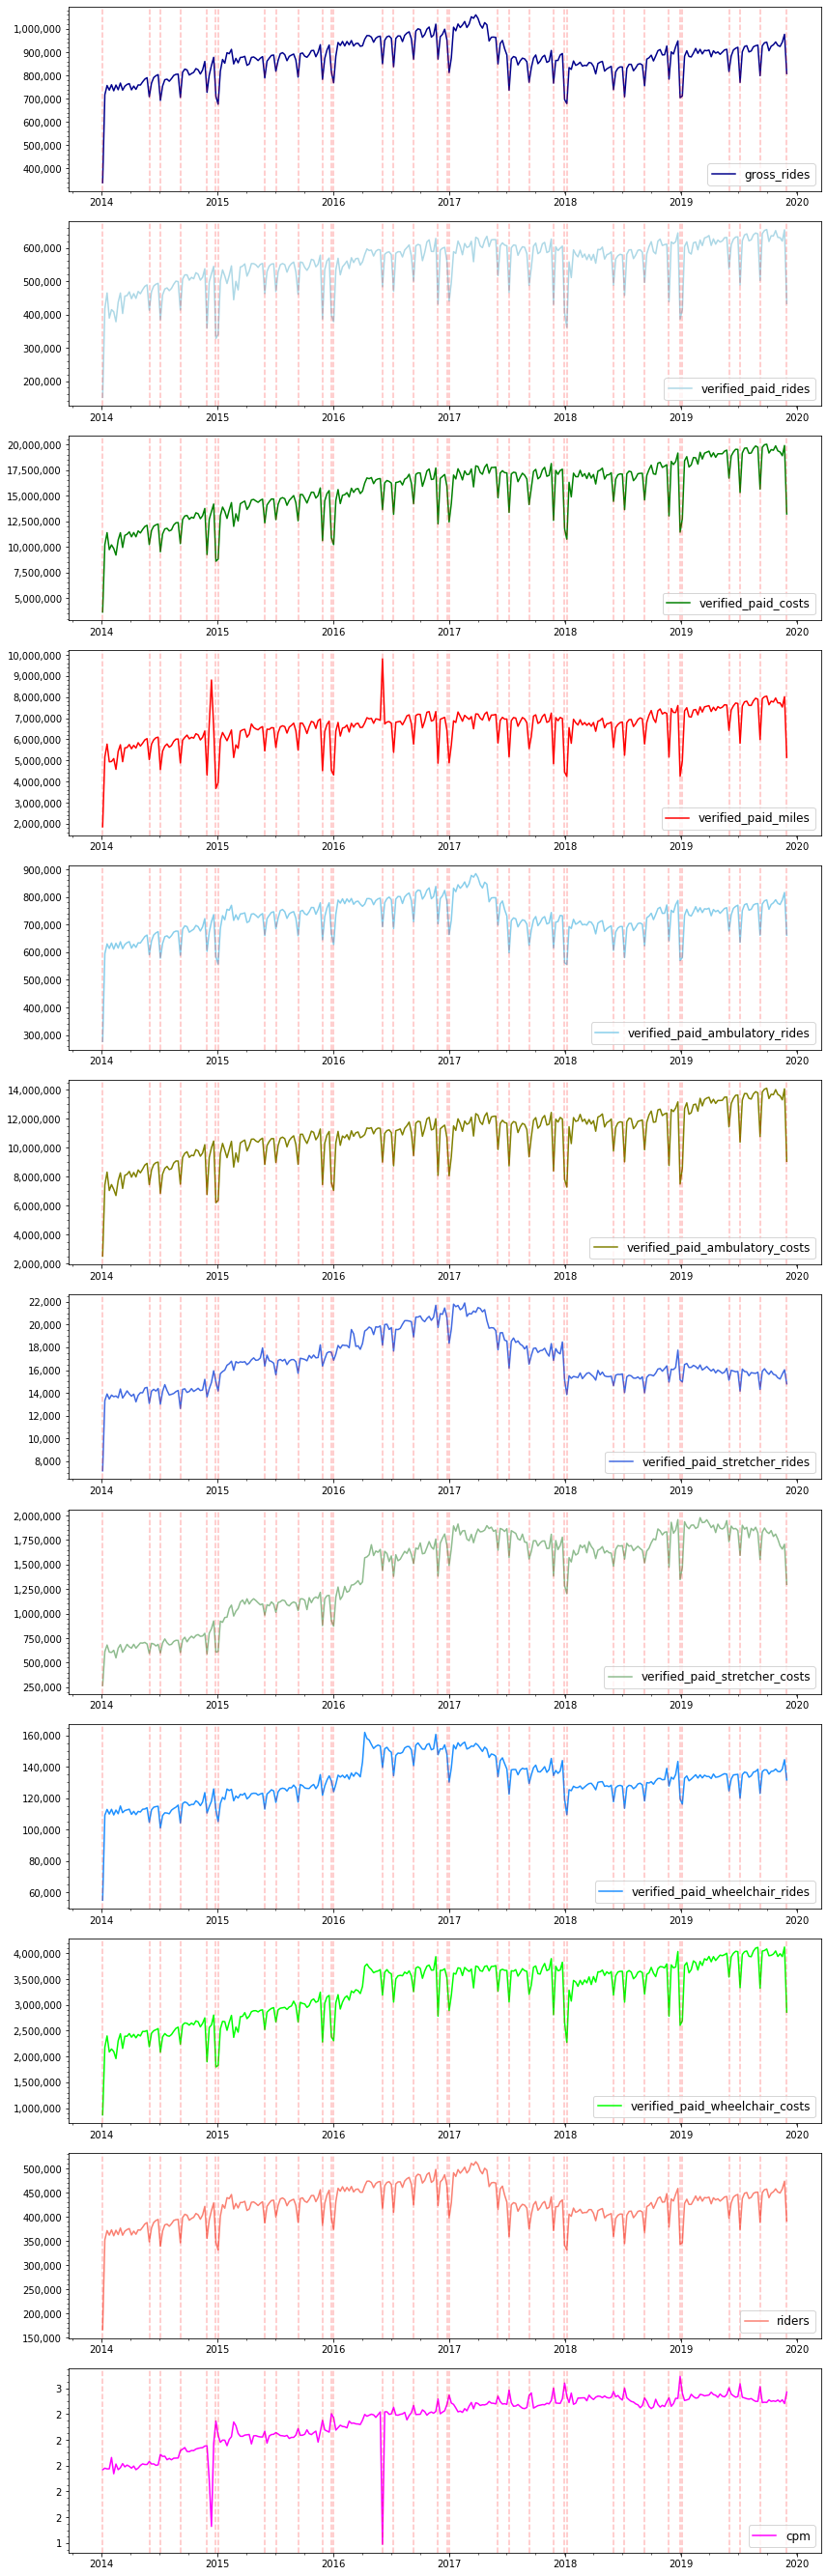

In [22]:
# need a loop to plot them all in subplots
colors = ['darkblue', 'lightblue', 'green', 'red',
          'skyblue', 'olive', 'royalblue', 'darkseagreen',
         'dodgerblue', 'lime', 'salmon', 'magenta']

# remove the warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib as mpl


fig, ax = plt.subplots(figsize = (12, 40))
for i, col in enumerate(list_columns):
    ax = plt.subplot(len(list_columns) + 1, 1, i+1)
    ax.plot(wdf.index.values, wdf.loc[:,list_columns[i]], label = list_columns[i], color = colors[i])
    # plot the legend for the first plot
    ax.legend(loc = 'lower right', fontsize = 12)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    # Initialize minor ticks
    ax.minorticks_on()
    
    # add the holiday indicators in
    for day in wdf.query('holiday==1').index:
        # add in a vertical line there
        ax.axvline(x=day, color='red', linestyle='--', alpha=.25);

plt.tight_layout()

plt.show()

In [23]:
# these are pairplots based on the weekly ride dataframe
# data is number or rides, weekly holiday indicator and ride volume
def make_pairplot(list_columns, relationship):
    g = sns.pairplot(wdf, vars = list_columns, hue="holiday", kind="reg")
    g.map_diag(sns.kdeplot, lw=2, legend=False)
    g.map_offdiag(plt.scatter)
    g.add_legend()

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(relationship + ' Relationships')

    xlabels,ylabels = [],[]

    for ax in g.axes[-1,:]:
        ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        xlabel = ax.xaxis.get_label_text()
        xlabels.append(xlabel)
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    for ax in g.axes[:,0]:
        ylabel = ax.yaxis.get_label_text()
        ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ylabels.append(ylabel)
    

    
    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            g.axes[j,i].xaxis.set_label_text(xlabels[i])
            g.axes[j,i].yaxis.set_label_text(ylabels[j])
        
    # set the figure size
    g.fig.set_size_inches(20,20)

    plt.show();

In [24]:
ride_cols = wdf.columns[wdf.columns.str.contains(pat = 'rides|cpm')]
ride_cols

Index(['gross_rides', 'verified_paid_rides', 'verified_paid_ambulatory_rides',
       'verified_paid_stretcher_rides', 'verified_paid_wheelchair_rides',
       'cpm'],
      dtype='object')

In [25]:
cost_cols = wdf.columns[wdf.columns.str.contains(pat = 'cost|miles')]
cost_cols

Index(['verified_paid_costs', 'verified_paid_miles',
       'verified_paid_ambulatory_costs', 'verified_paid_stretcher_costs',
       'verified_paid_wheelchair_costs'],
      dtype='object')

# Rides and Miles Relationship

## - As gross rides increases, CPM increases -- near capacity?
## - At the aggregate, non-holiday costs increase more than holiday costs, driven by ambulatory volume
## - Stretcher and Wheelchair change the holiday dynamic
## - CPM has wider spread on holidays

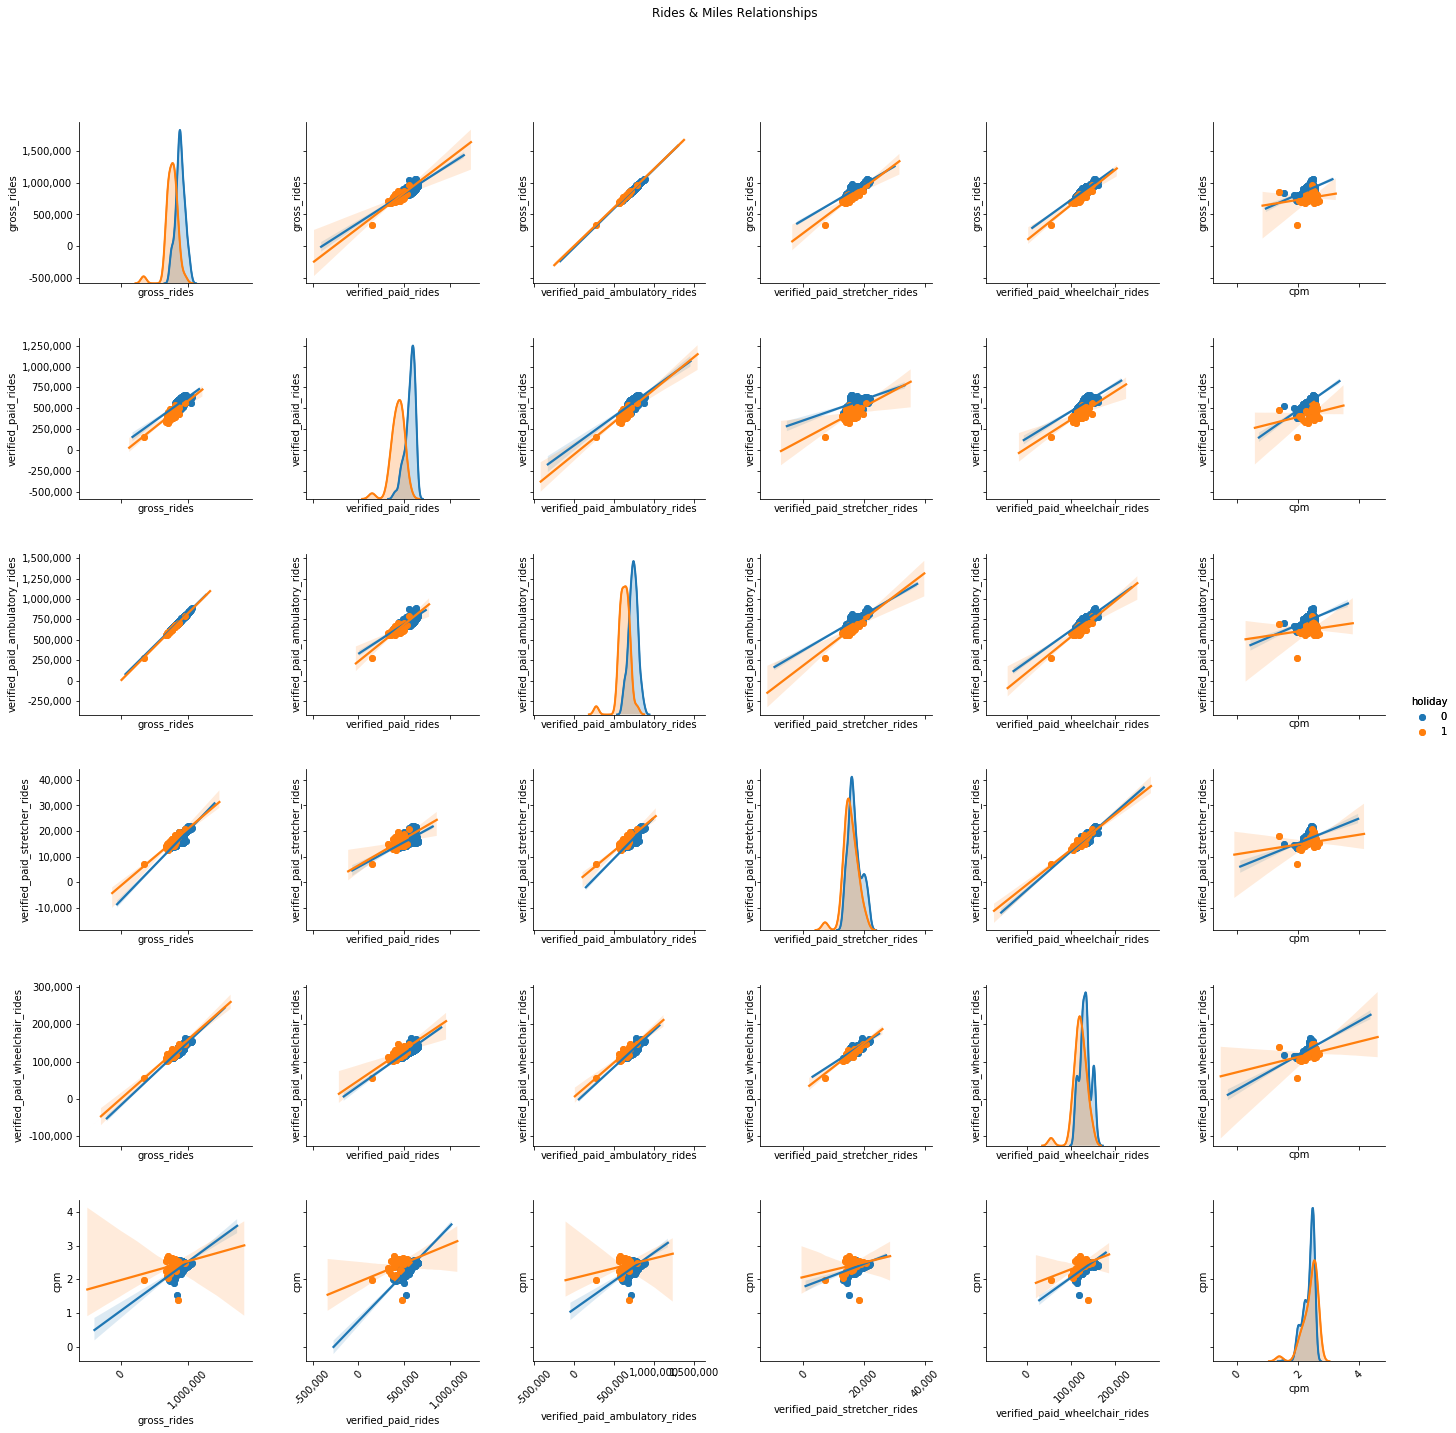

In [26]:
make_pairplot(ride_cols, 'Rides & Miles')

# Cost and Miles Relationships
## - On holidays, ver paid costs do not rise as much with miles
## - Stretcher costs much more sensitive to miles for non-holidays
## - Non-holiday ambulatory costs are most sensitive to miles

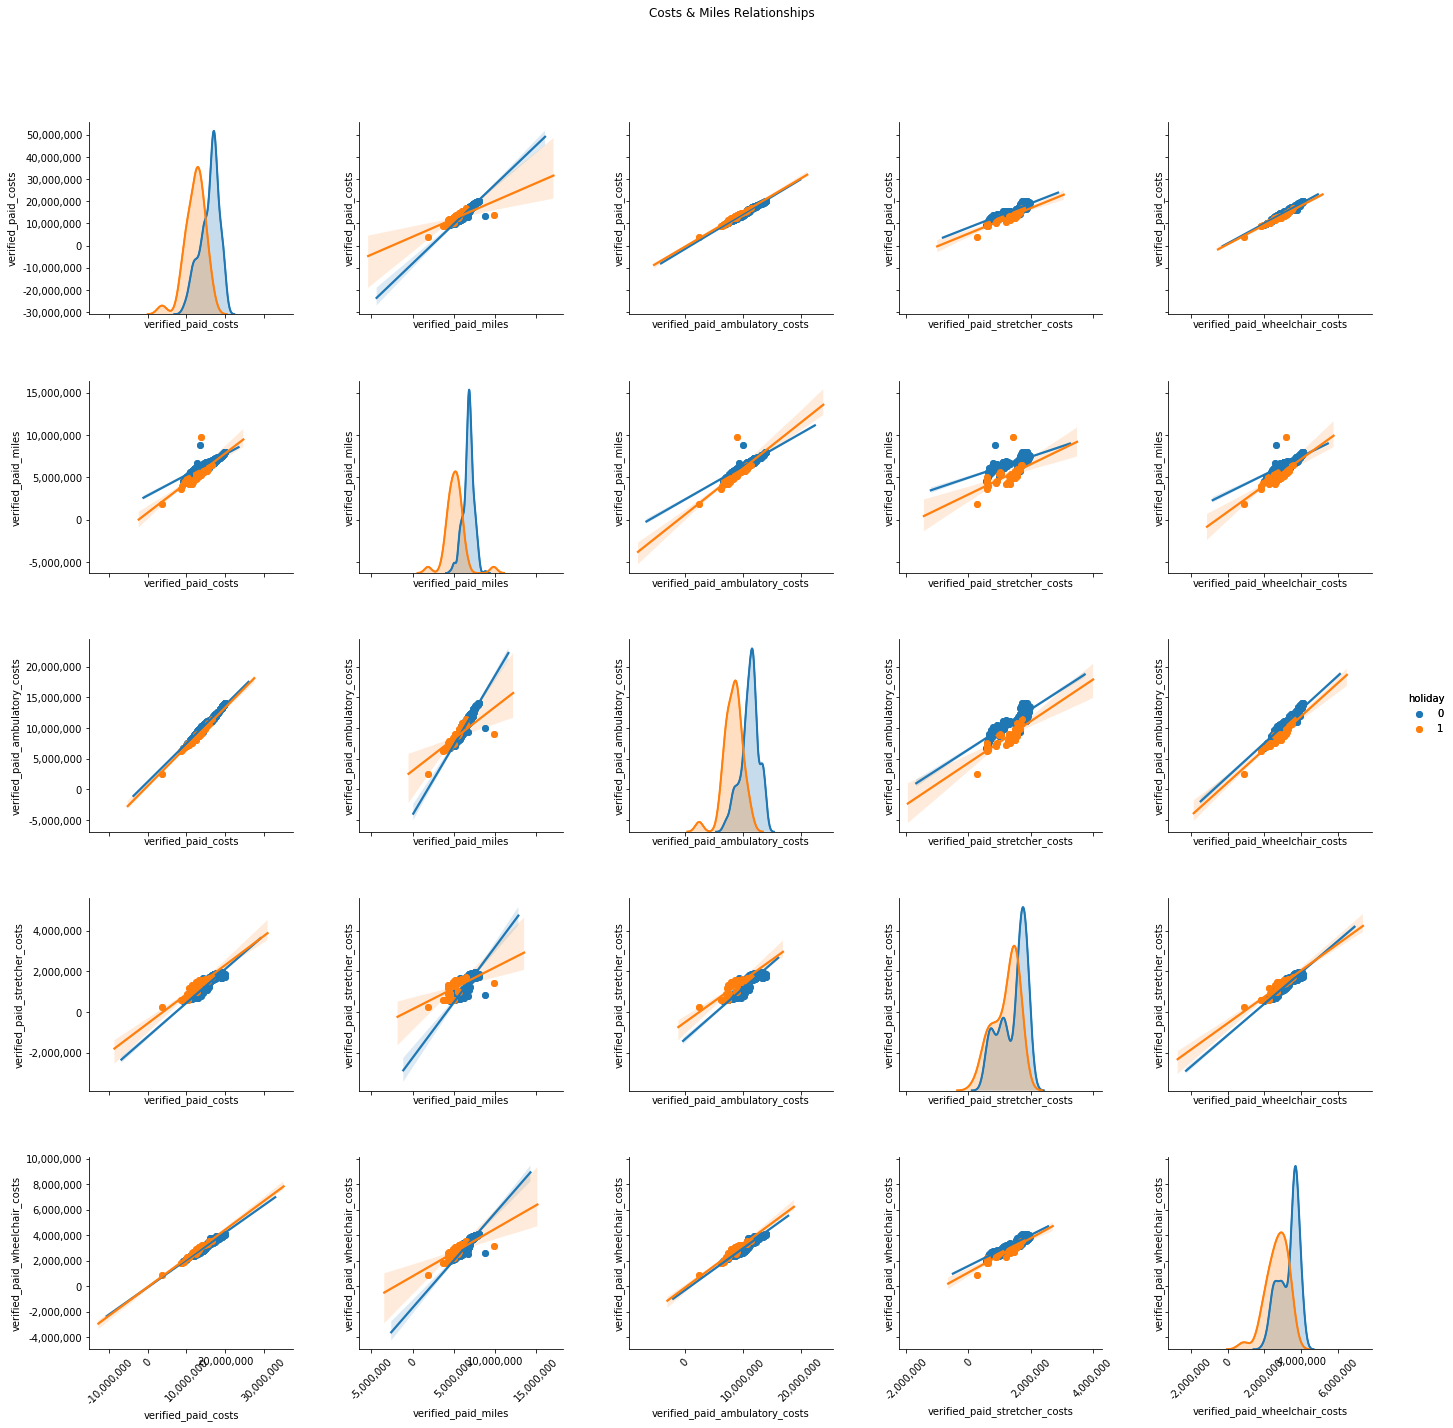

In [27]:
make_pairplot(cost_cols, 'Costs & Miles')

In [28]:
list_columns

['gross_rides',
 'verified_paid_rides',
 'verified_paid_costs',
 'verified_paid_miles',
 'verified_paid_ambulatory_rides',
 'verified_paid_ambulatory_costs',
 'verified_paid_stretcher_rides',
 'verified_paid_stretcher_costs',
 'verified_paid_wheelchair_rides',
 'verified_paid_wheelchair_costs',
 'riders',
 'cpm']

# Most Series are non-Stationary (have a trend)
## - Verified paid rides is stationary

In [29]:
# apply the function to each column for rides
wdf.apply(lambda x: adf_test(x, title = x.name) if x.name in ride_cols else None)

Augmented Dickey-Fuller Test: gross_rides
ADF test statistic       -2.444768
p-value                   0.129497
# lags used              10.000000
# observations          298.000000
critical value (1%)      -3.452486
critical value (5%)      -2.871288
critical value (10%)     -2.571964
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: verified_paid_rides
ADF test statistic       -3.495254
p-value                   0.008110
# lags used               4.000000
# observations          304.000000
critical value (1%)      -3.452045
critical value (5%)      -2.871095
critical value (10%)     -2.571861
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: verified_paid_ambulatory_rides
ADF test statistic       -2.636169
p-value                   0.085750
# lags used              10.000000
# observations       

holiday                           None
gross_rides                       None
verified_paid_rides               None
verified_paid_costs               None
verified_paid_miles               None
verified_paid_ambulatory_rides    None
verified_paid_ambulatory_costs    None
verified_paid_stretcher_rides     None
verified_paid_stretcher_costs     None
verified_paid_wheelchair_rides    None
verified_paid_wheelchair_costs    None
riders                            None
cpm                               None
dtype: object

# Verified Paid Miles and Verified Paid Ambulatory Costs are Stationary
## - May still require seasonal differencing to accurately model series

In [30]:
# apply the function to each column for costs
wdf.apply(lambda x: adf_test(x, title = x.name) if x.name in cost_cols else None)

Augmented Dickey-Fuller Test: verified_paid_costs
ADF test statistic       -2.008220
p-value                   0.282980
# lags used              11.000000
# observations          297.000000
critical value (1%)      -3.452561
critical value (5%)      -2.871321
critical value (10%)     -2.571982
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: verified_paid_miles
ADF test statistic       -3.121105
p-value                   0.025030
# lags used               7.000000
# observations          301.000000
critical value (1%)      -3.452263
critical value (5%)      -2.871191
critical value (10%)     -2.571912
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: verified_paid_ambulatory_costs
ADF test statistic       -2.286267
p-value                   0.176435
# lags used              10.000000
# observation

holiday                           None
gross_rides                       None
verified_paid_rides               None
verified_paid_costs               None
verified_paid_miles               None
verified_paid_ambulatory_rides    None
verified_paid_ambulatory_costs    None
verified_paid_stretcher_rides     None
verified_paid_stretcher_costs     None
verified_paid_wheelchair_rides    None
verified_paid_wheelchair_costs    None
riders                            None
cpm                               None
dtype: object

In [31]:
def test_decomp(x, title = ""):
    mpl.rc('figure', max_open_warning = 0)
    decomposition = seasonal_decompose(x, model = 'multiplicative', freq=7)  
    fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(16, 8)
    fig.suptitle(title, y = 1.05, fontsize=16);

In [32]:
# create a function for seasonal decomp
# decompose the series
# daily seasonality

def clean_decomp(x, title = ''):
    result = seasonal_decompose(x, model = 'multiplicative')
    rcParams['figure.figsize'] = 16,8
    decomp_plot = result.plot()
    
    return decomp_plot

# All Seasonal Components are Bi-modal
## - Most series show trend peaking in beginning of 2017

holiday                           None
gross_rides                       None
verified_paid_rides               None
verified_paid_costs               None
verified_paid_miles               None
verified_paid_ambulatory_rides    None
verified_paid_ambulatory_costs    None
verified_paid_stretcher_rides     None
verified_paid_stretcher_costs     None
verified_paid_wheelchair_rides    None
verified_paid_wheelchair_costs    None
riders                            None
cpm                               None
dtype: object

<Figure size 432x288 with 0 Axes>

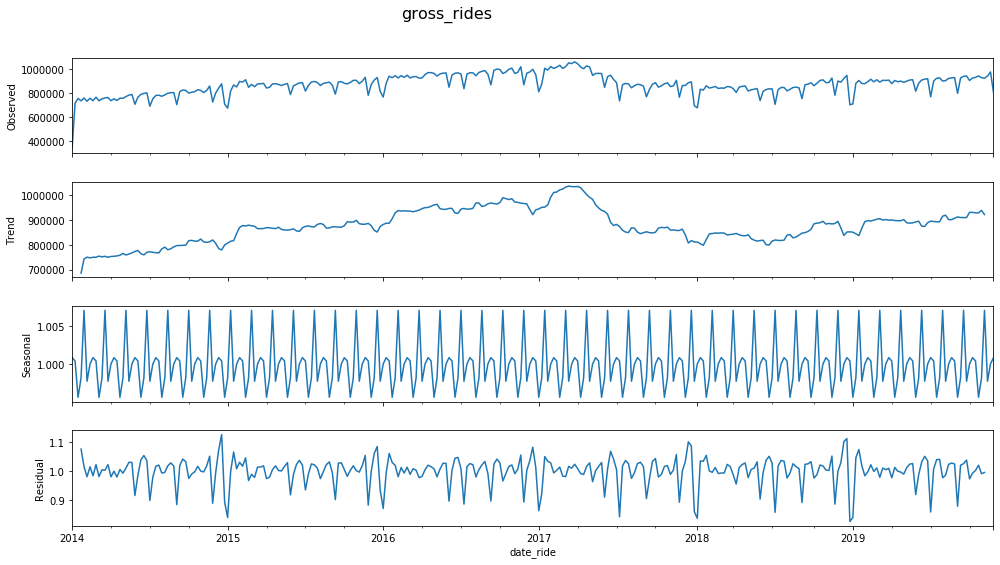

<Figure size 432x288 with 0 Axes>

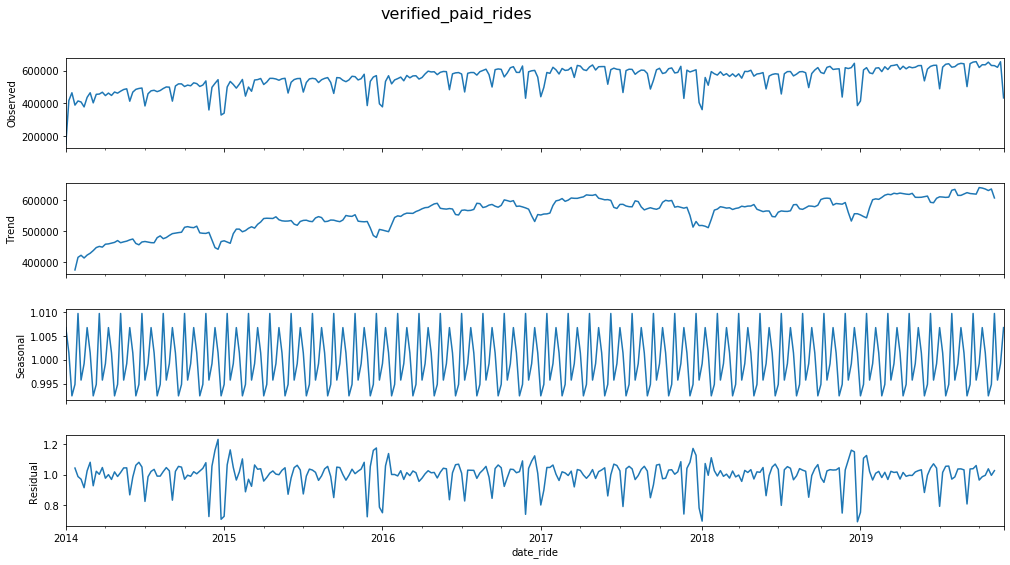

<Figure size 432x288 with 0 Axes>

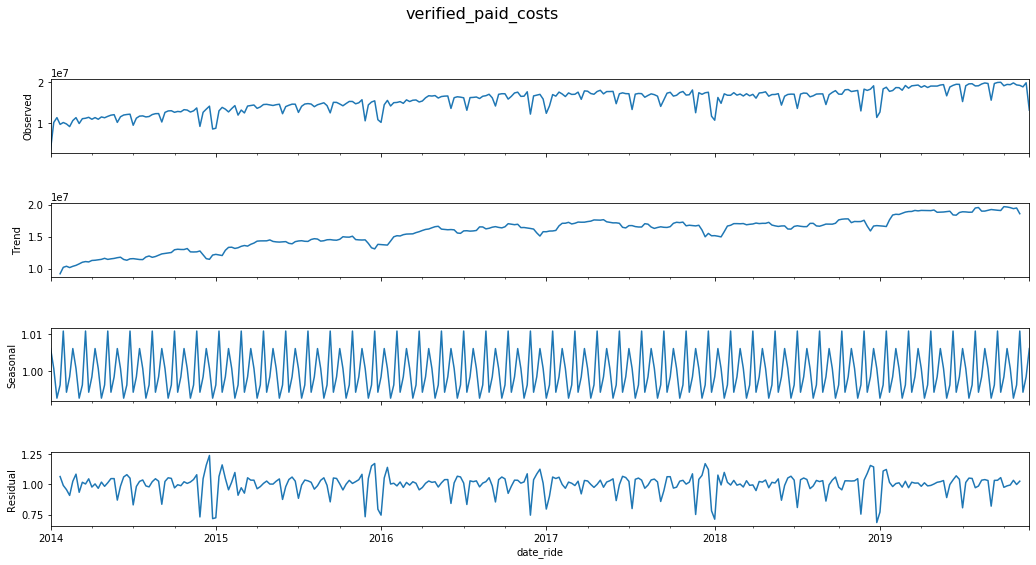

<Figure size 432x288 with 0 Axes>

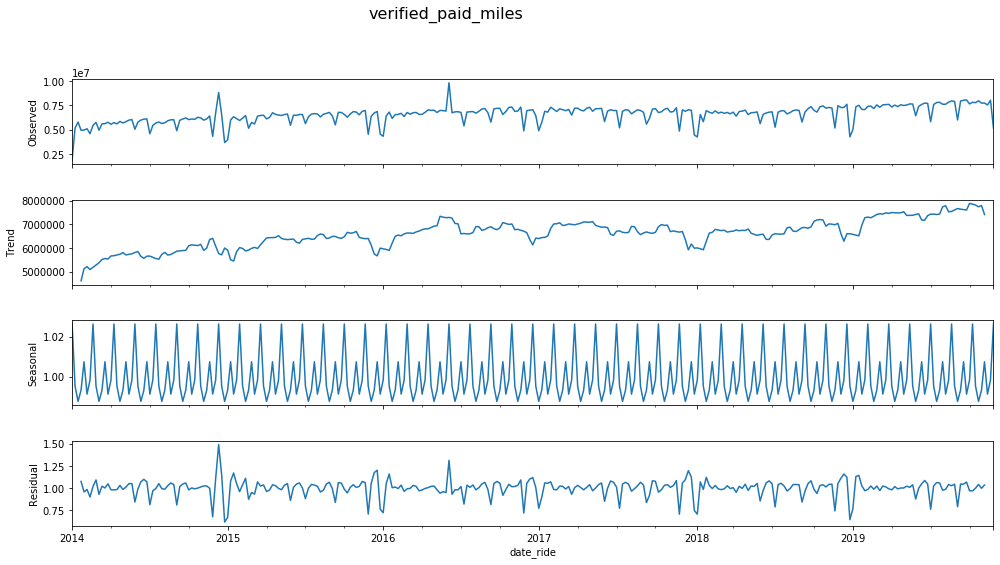

<Figure size 432x288 with 0 Axes>

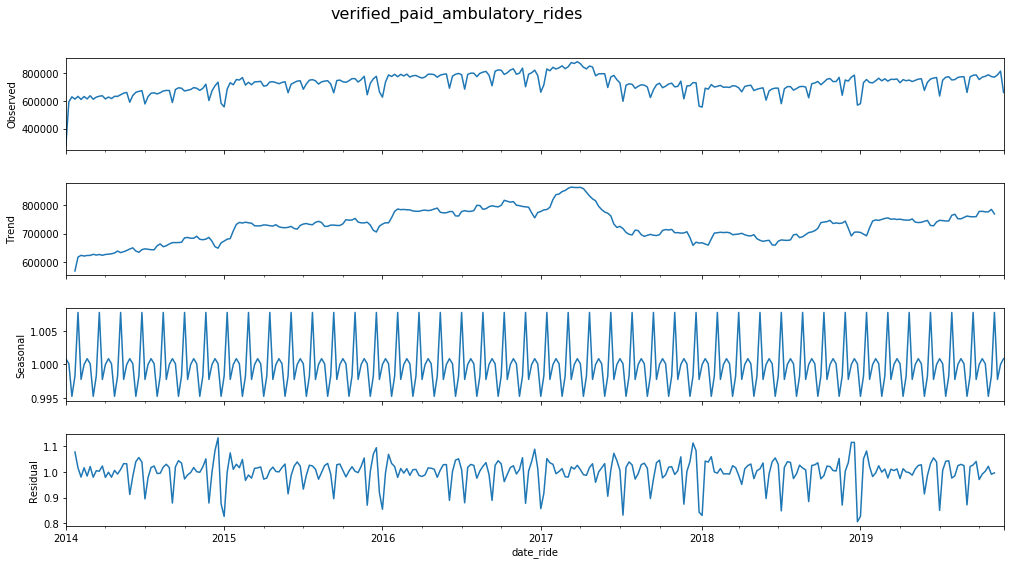

<Figure size 432x288 with 0 Axes>

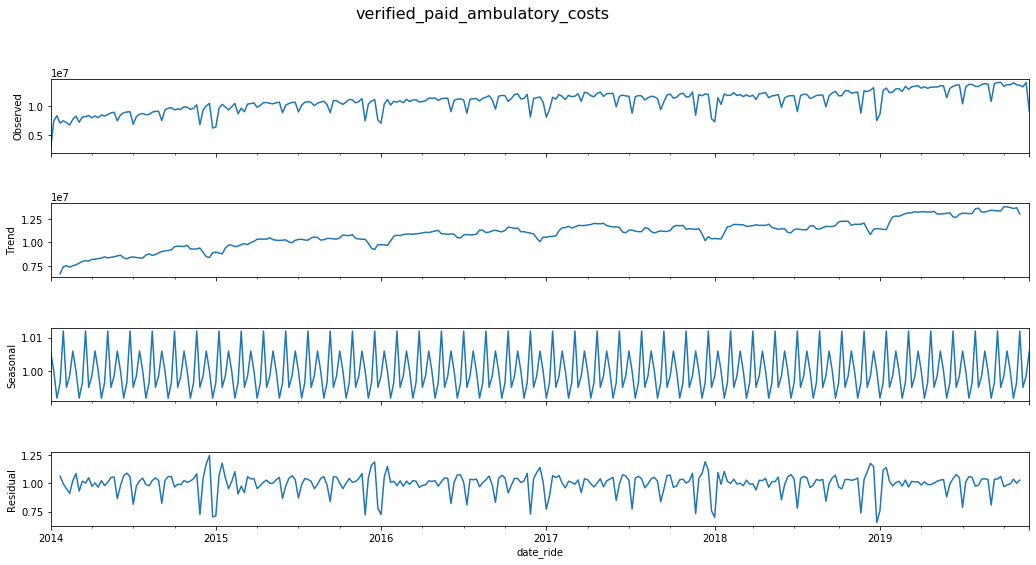

<Figure size 432x288 with 0 Axes>

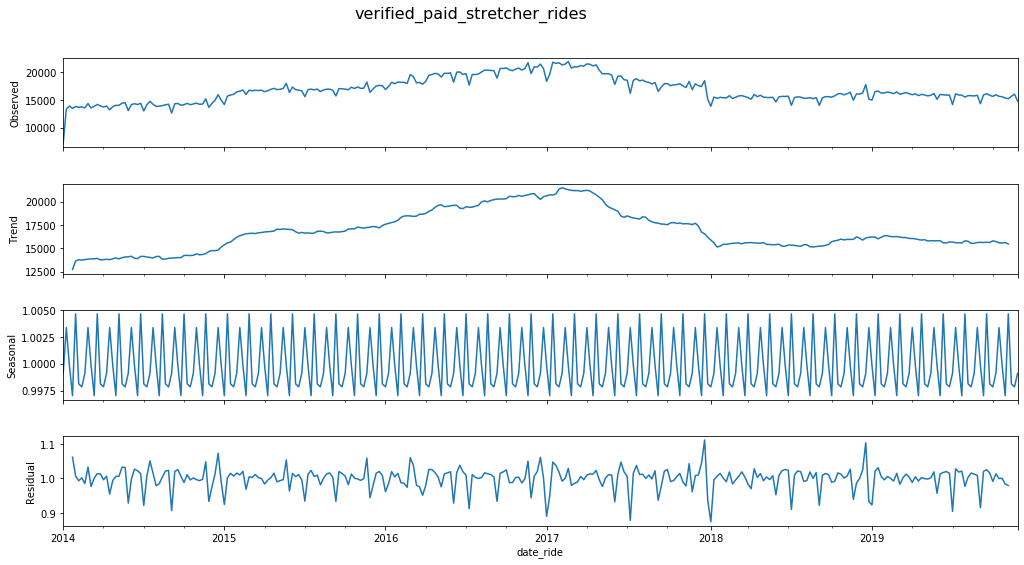

<Figure size 432x288 with 0 Axes>

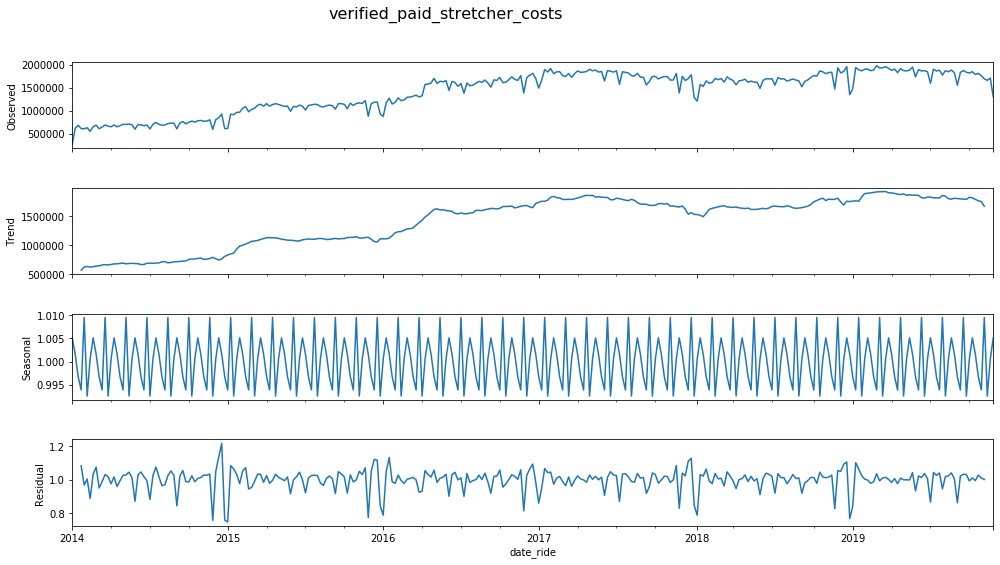

<Figure size 432x288 with 0 Axes>

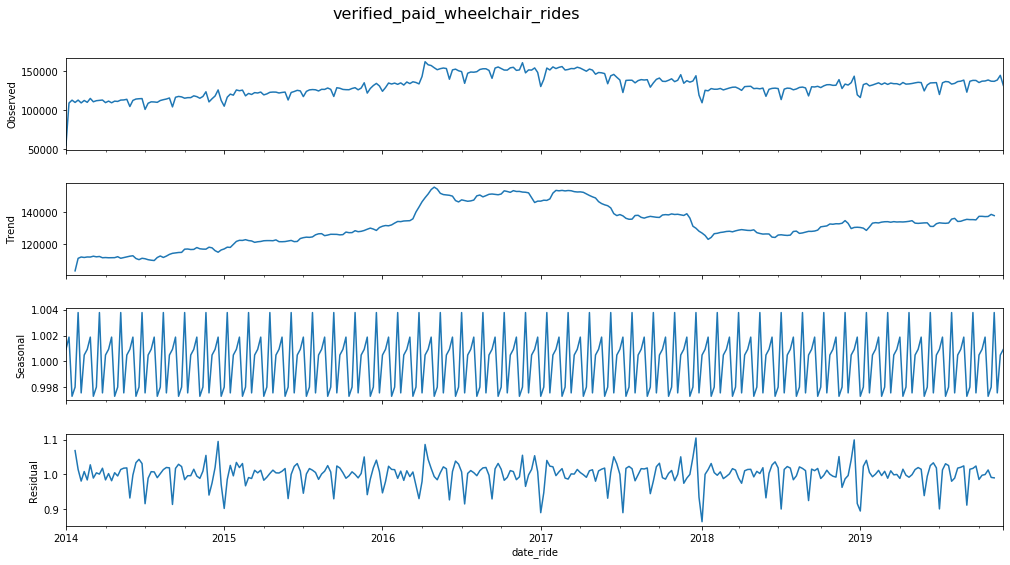

<Figure size 432x288 with 0 Axes>

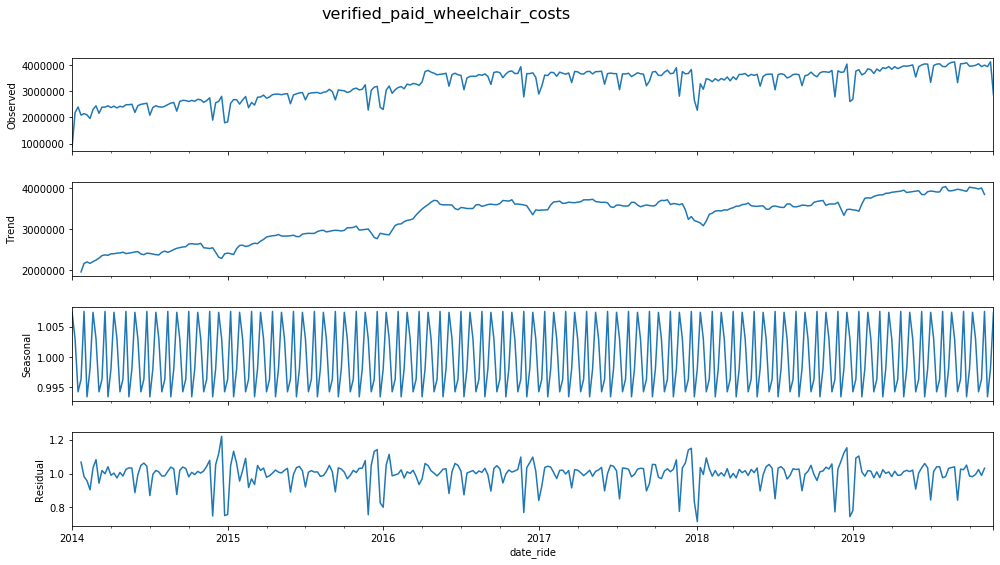

<Figure size 432x288 with 0 Axes>

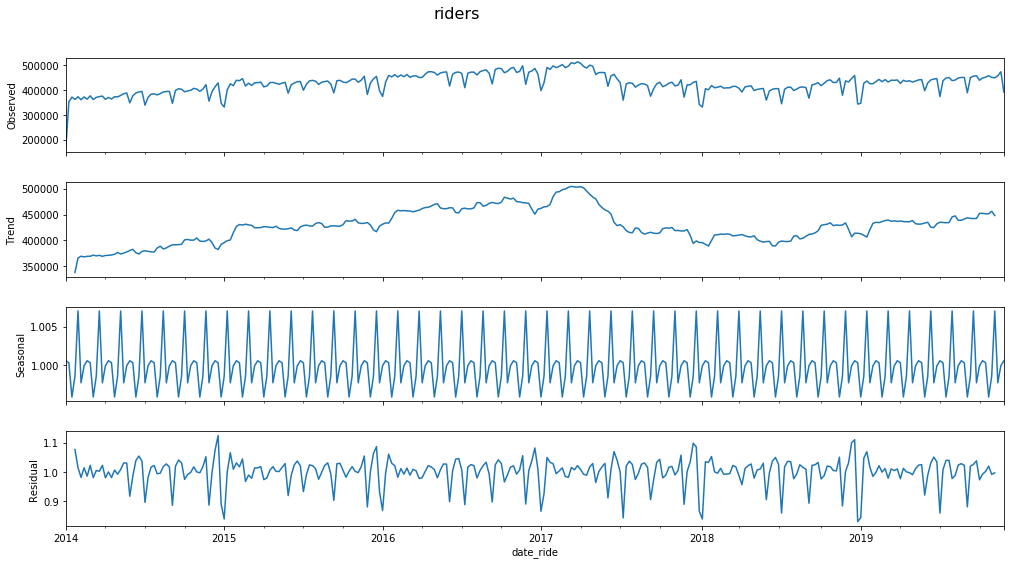

<Figure size 432x288 with 0 Axes>

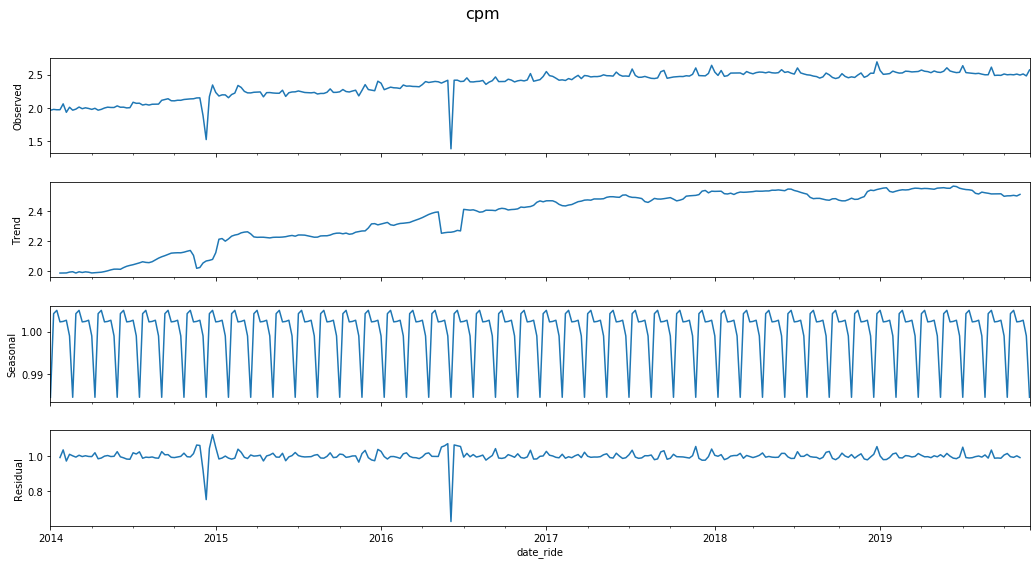

In [33]:
wdf.apply(lambda x: test_decomp(x, title = x.name) if x.name in list_columns else None)

In [34]:
# make correlation plots
# get an acf plot

def acf_plot(series, title = ''):
    N, M = 12, 6
    fig, ax = plt.subplots(figsize=(N, M))
    plot_acf(series, lags=40, ax=ax, title = title + " Autocorrelation")
    plt.show()
    
    
def pacf_plot(series, title = ''):
    N, M = 12, 6
    fig, ax = plt.subplots(figsize=(N, M))
    plot_pacf(series, lags=40, ax=ax, title = title + " Partial Autocorrelation")
    plt.show()

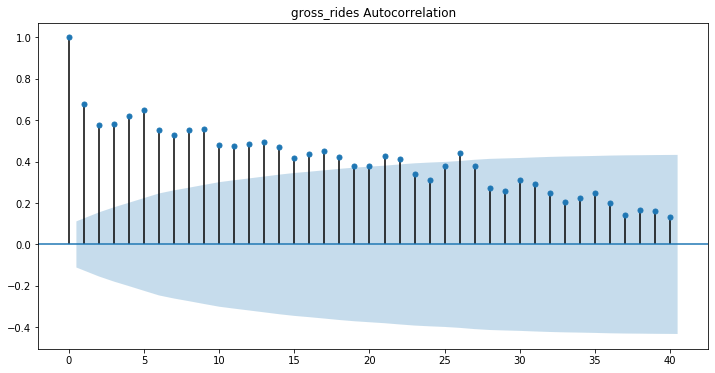

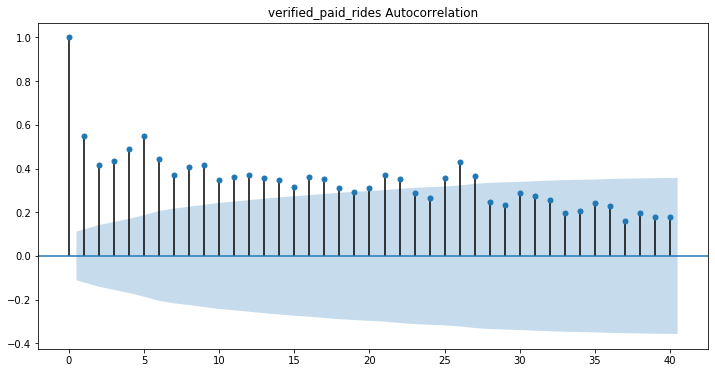

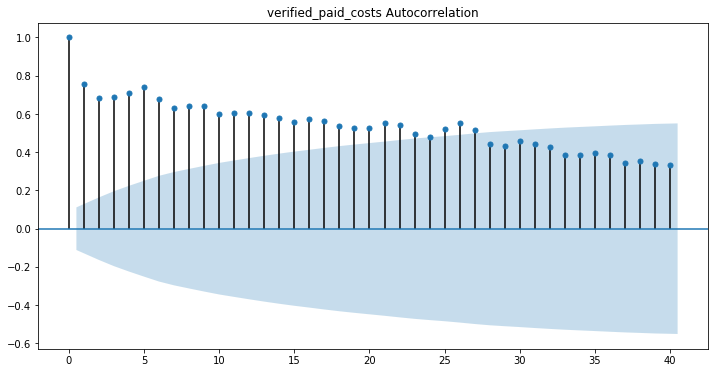

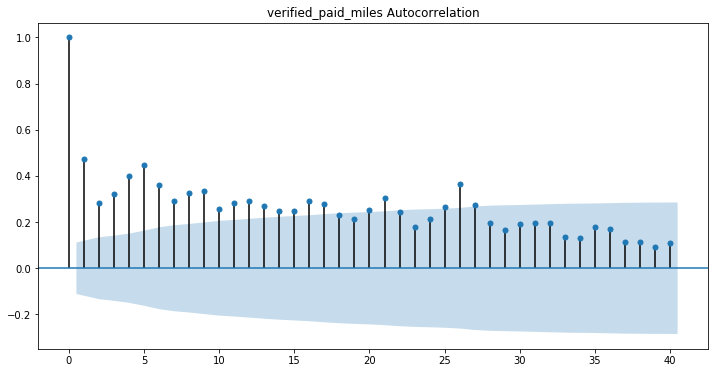

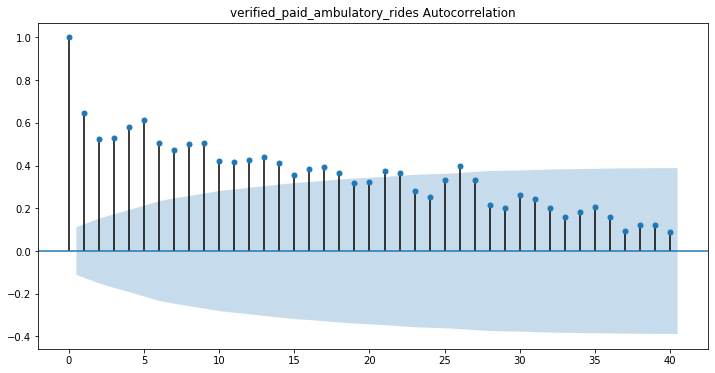

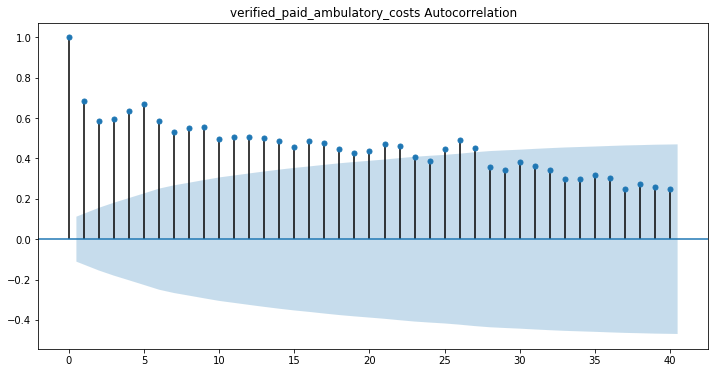

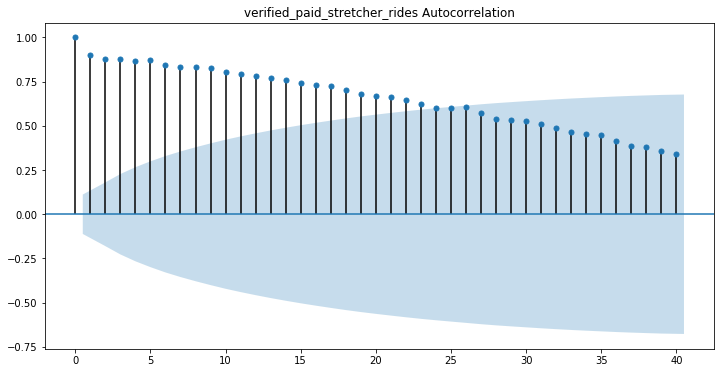

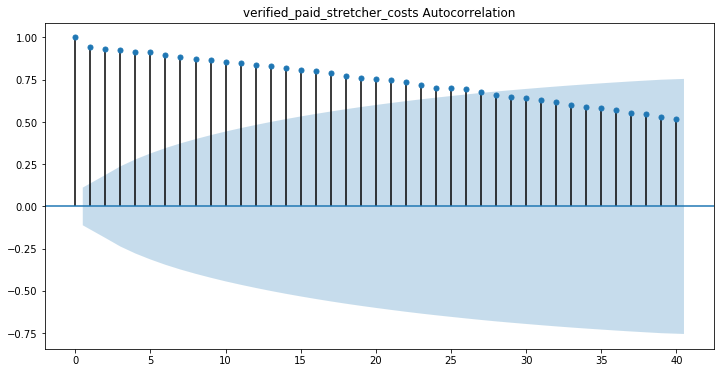

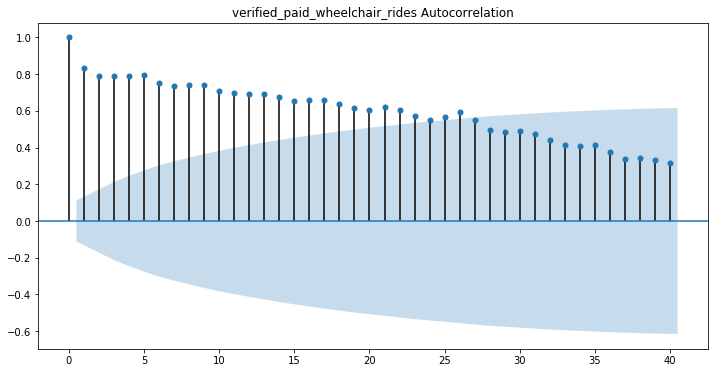

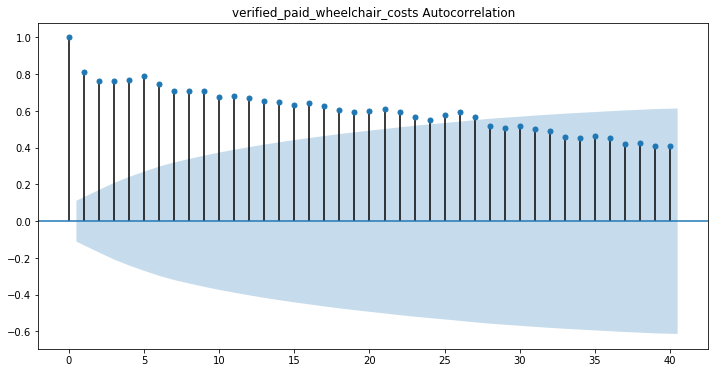

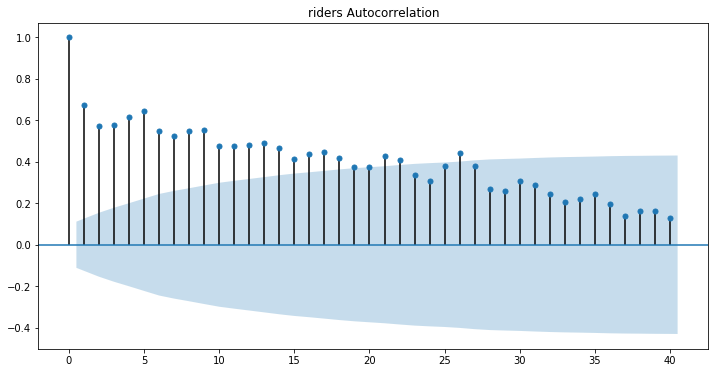

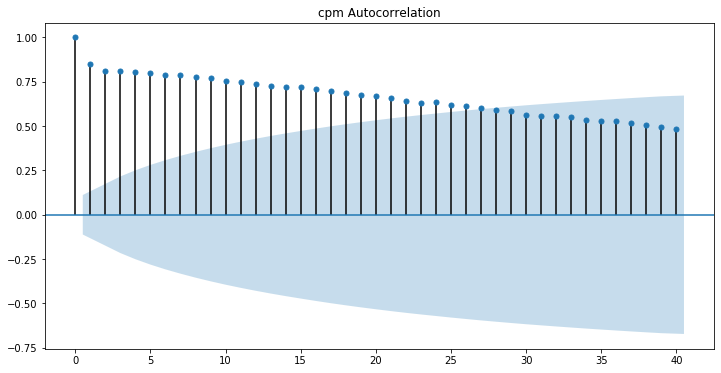

holiday                           None
gross_rides                       None
verified_paid_rides               None
verified_paid_costs               None
verified_paid_miles               None
verified_paid_ambulatory_rides    None
verified_paid_ambulatory_costs    None
verified_paid_stretcher_rides     None
verified_paid_stretcher_costs     None
verified_paid_wheelchair_rides    None
verified_paid_wheelchair_costs    None
riders                            None
cpm                               None
dtype: object

In [35]:
wdf.apply(lambda x: acf_plot(x, title = x.name) if x.name in list_columns else None)

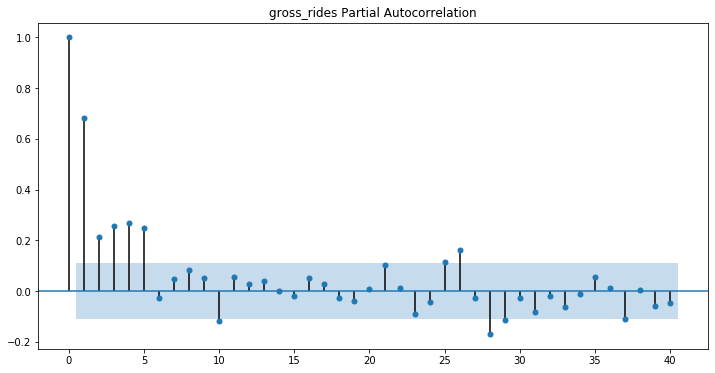

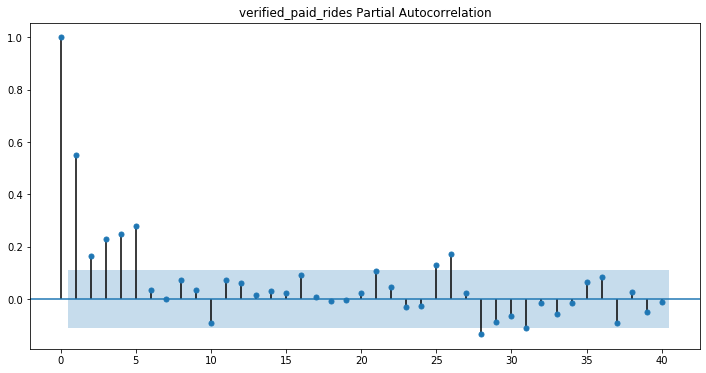

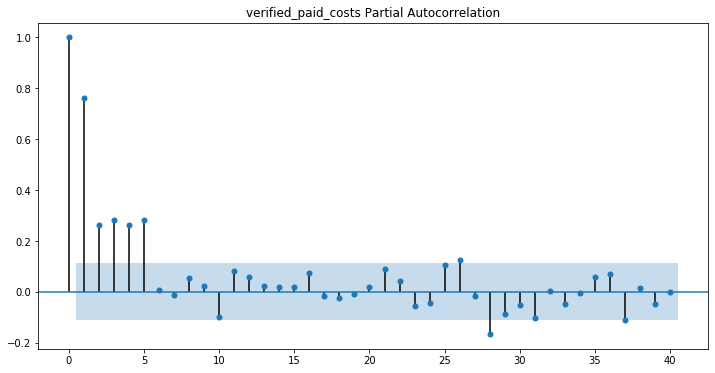

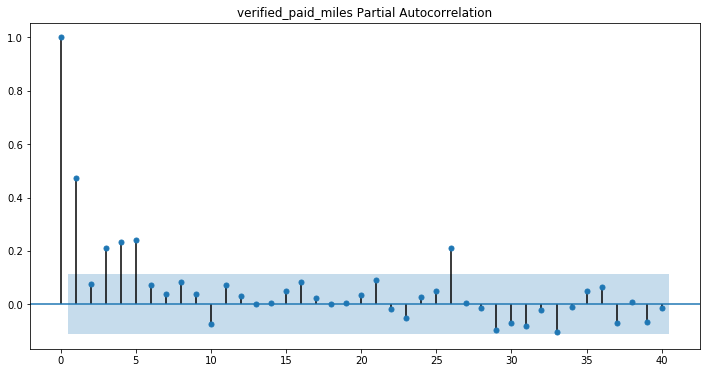

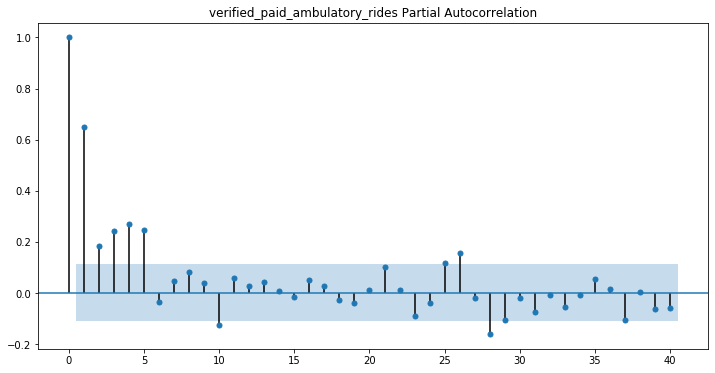

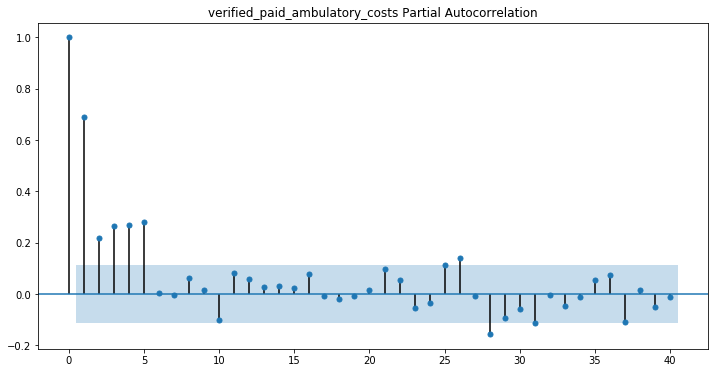

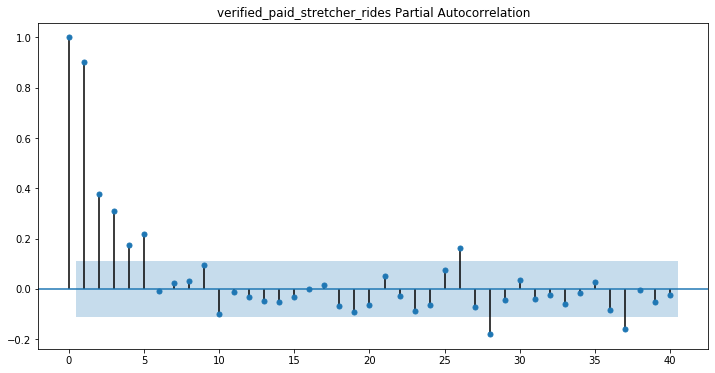

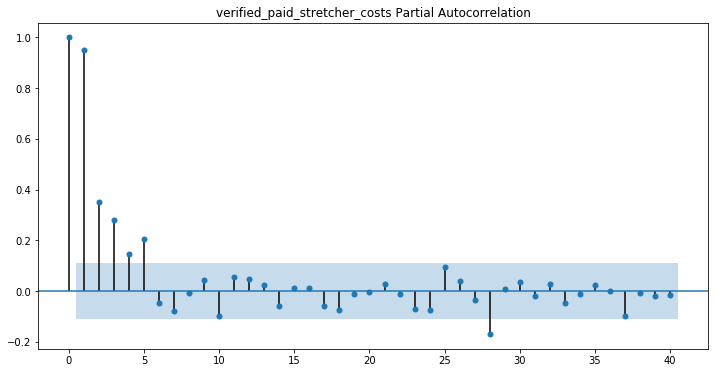

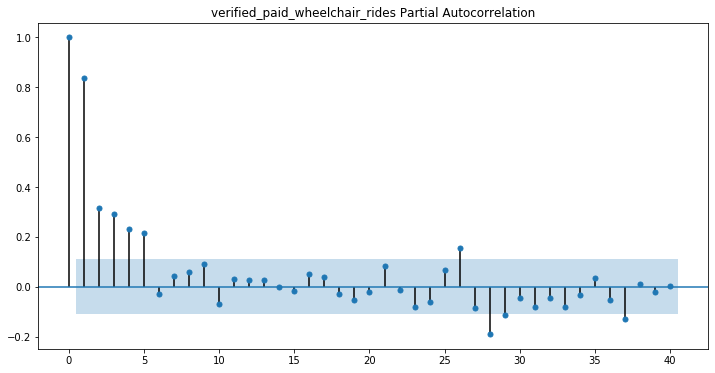

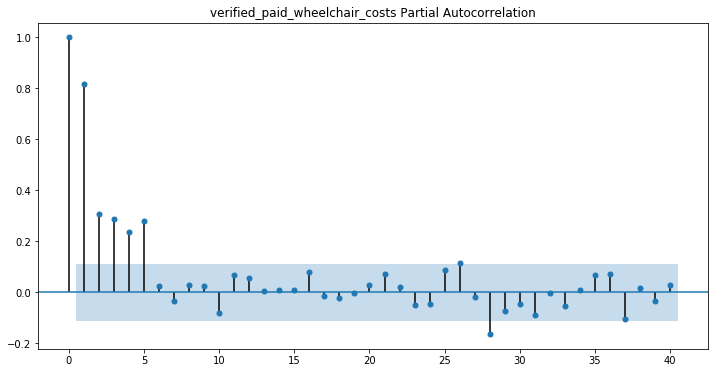

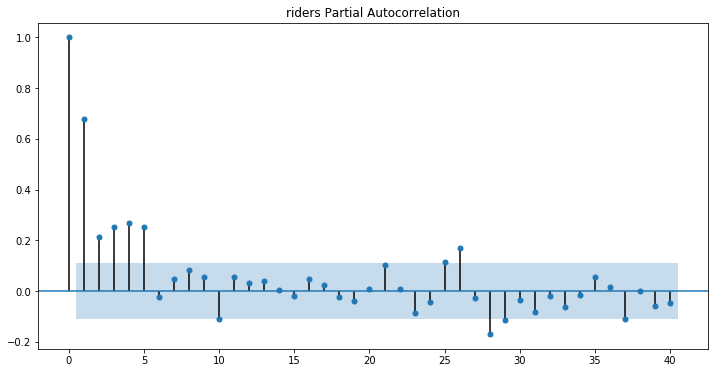

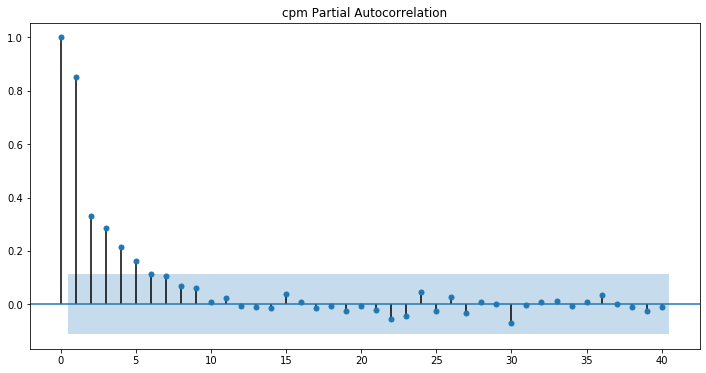

holiday                           None
gross_rides                       None
verified_paid_rides               None
verified_paid_costs               None
verified_paid_miles               None
verified_paid_ambulatory_rides    None
verified_paid_ambulatory_costs    None
verified_paid_stretcher_rides     None
verified_paid_stretcher_costs     None
verified_paid_wheelchair_rides    None
verified_paid_wheelchair_costs    None
riders                            None
cpm                               None
dtype: object

In [36]:
wdf.apply(lambda x: pacf_plot(x, title = x.name) if x.name in list_columns else None)

In [37]:
# trim the dataset to remove partial weeks

wdf_trim = wdf.iloc[1:len(wdf)-1,0:]

wdf_trim.head()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2014-01-12        0       716978               417251          10218253.61   
2014-01-19        0       756659               464330          11398957.14   
2014-01-26        0       736904               388920           9745250.59   
2014-02-02        0       759988               414369          10209757.24   
2014-02-09        0       734042               407991           9852916.99   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2014-01-12              5160147                          594478   
2014-01-19              5772414                          629920   
2014-01-26              4933421                          613532   
2014-02-02              4948844                          633274   
2014-02-09              5086865                          611062   

            verified_paid_ambulatory_costs  verified_paid_stretcher_rides  \
date_ride                                                                   
2014-01-12                      7425178.64                          13331   
2014-01-19                      8320541.03                          13909   
2014-01-26                      7050347.37                          13468   
2014-02-02                      7460196.84                          13810   
2014-02-09                      7129966.30                          13669   

            verified_paid_stretcher_costs  verified_paid_wheelchair_rides  \
date_ride                                                                   
2014-01-12                      611998.27                          109169   
2014-01-19                      679684.35                          112830   
2014-01-26                      607413.60                          109904   
2014-02-02                      604284.39                          112904   
2014-02-09                      626212.70                          109311   

            verified_paid_wheelchair_costs  riders       cpm  
date_ride                                                     
2014-01-12                      2181076.70  352948  1.980225  
2014-01-19                      2398731.76  371953  1.974730  
2014-01-26                      2087489.62  362595  1.975354  
2014-02-02                      2145276.01  373441  2.063059  
2014-02-09                      2096737.99  361216  1.936933

# Functions for Modeling

In [38]:
wdf.tail()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2019-11-03        0       929136               631122          19377294.99   
2019-11-10        0       924579               630229          19269847.92   
2019-11-17        0       943000               619960          18904863.26   
2019-11-24        0       976656               653886          19900848.48   
2019-12-01        1       808175               432861          13225024.83   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2019-11-03              7724463                          776778   
2019-11-10              7726481                          772494   
2019-11-17              7530496                          788800   
2019-11-24              8020524                          816091   
2019-12-01              5145459                          661766   

            verified_paid_ambulatory_costs  verified_paid_stretcher_rides  \
date_ride                                                                   
2019-11-03                     13678580.33                          15330   
2019-11-10                     13584170.61                          15221   
2019-11-17                     13309000.48                          15647   
2019-11-24                     14070924.89                          16032   
2019-12-01                      9065523.09                          14801   

            verified_paid_stretcher_costs  verified_paid_wheelchair_rides  \
date_ride                                                                   
2019-11-03                     1758509.45                          137028   
2019-11-10                     1691651.35                          136864   
2019-11-17                     1657833.87                          138553   
2019-11-24                     1706765.62                          144533   
2019-12-01                     1298558.30                          131608   

            verified_paid_wheelchair_costs  riders       cpm  
date_ride                                                     
2019-11-03                      3940205.21  451817  2.508562  
2019-11-10                      3994025.96  449730  2.494001  
2019-11-17                      3938028.91  458162  2.510441  
2019-11-24                      4123157.97  474154  2.481240  
2019-12-01                      2860943.44  392008  2.570232

In [72]:
# set forecast horizon

horizon = 12

fcast = len(wdf) - horizon

# cut the data
train = wdf.iloc[0:fcast]
test = wdf.iloc[fcast:]

In [73]:
# set up for forecasting and backtesting
# set the ranges
exog_forecast = test[['holiday']]

start = len(train)
end = len(train) + len(test)-1 

print(start)
print(end)

297
308


In [41]:
# make the model

def build_model(series, p, d, q, S, exog_data, P=None, D=None, Q=None):
    if P is None:
        P = p
    if D is None:
        D = d
    if Q is None:
        Q = q
    model = SARIMAX(series, order=(p,d,q),
                    seasonal_order=(P,D,Q,S),
                    exog=exog_data,
                    enforce_invertibility=True)
    results = model.fit()
    return results

In [42]:
# check the Durbin-Watson Statistic of Residuals
# look for a value close to 2

def get_dw(model):
    resid = model.resid
    return dw(resid)

In [43]:
# make the backtest model to compare

def backtest_model(model_results, exog_data, start=1, end=start-1,name='Backtest Model'):
    results = model_results.predict(start=1,
                    end=start-1,
                    exog=exog_data,
                    typ='levels').rename(name)
    return results

In [44]:
# make the predictions from start to end

def make_predictions(model_results, model_name, start, end, exog_data):
    predictions = model_results.predict(start=start,
                                        end=end,
                                        exog=exog_data).rename(model_name)
    return predictions

In [404]:
# check full fit
# make a plot of model fit

def plot_fit(series, backtest_model, train, decimal = False):

    # series is training data
    ax = series.plot(figsize=(16,8), legend=True)
    ax1 = backtest_model.plot(legend=True)
    ax.legend(loc='upper right')
    
    if decimal:
        ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
        
    else:
        ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    # add the holiday indicators in
    for day in train.query('holiday==1').index:
        # add in a vertical line there 
        ax.axvline(x=day, color='red', linestyle='--', alpha=.25);

In [65]:
wdf.index[-1]

Timestamp('2019-12-01 00:00:00', freq='W-SUN')

In [61]:
# set the verified paid end date

vp_end_date = datetime.now().date() + timedelta(days=-66)
vp_end_date

datetime.date(2019, 10, 29)

In [407]:
# test the predictions
# make a plot of model fit

def prediction_plot(series, predictions, vp = False, decimal=False):
    # series is usually the test data
    if vp:
        vp_end_date = datetime.now().date() + timedelta(days=-66)
        
    else:
        vp_end_date = wdf.index[-1]
    
    ax = series.loc[:vp_end_date].plot(figsize=(16,8), legend=True)
    ax1 = predictions.plot(legend=True)
    
    if decimal:
        ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
        
    else:
        ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    for day in test.query('holiday==1').index:
        # add in a vertical line there
        ax.axvline(x=day, color='red', linestyle='--', alpha=.25);

In [104]:
def compare_results(test_data, predictions, vp = True):
    new_df = pd.concat([test_data, predictions], axis = 1 )
    
    if vp:
        vp_end_date = datetime.now().date() + timedelta(days=-66)
        
    else:
        vp_end_date = wdf.index[-1]
        
    new_df = new_df[:vp_end_date]
        
        
    return new_df

In [68]:
# calculate periodic error
def error_calcs(df, modeled, actual):
    df['Error'] = actual - modeled
    df['Percent'] = df['Error']/actual* 100
    list_cols = df.columns
    
    return df.style.format({list_cols[0]: "{:,.0f}".format,
                            list_cols[1]: "{:,.0f}".format,
                            list_cols[2]: "{:,.0f}".format,
                            list_cols[3]: "{:,.2f}".format})

In [112]:
def calculate_total_error(actual, predictions, vp = True):
    if vp:
        vp_end_date = datetime.now().date() + timedelta(days=-66)
        
    else:
        vp_end_date = wdf.index[-1]
    
    
    actual = actual[:vp_end_date]
    predictions = predictions[:vp_end_date]
    
    error = rmse(actual, predictions)
    print(f'{error:.0f}', 'RMSE')
    
    CancMean = actual.mean()
    print(f'{CancMean:.0f}', 'Mean of Rides')
    
    percent = error/CancMean*100
    print(f'{percent:.1f}', '% Error')

In [116]:
def get_conf_interval(model, actual, steps_ahead, predictions, exog_data=test[['holiday']], vp=True):
    
    
    predictions_int = model.get_forecast(steps=steps_ahead,exog=exog_data, alpha = .05)
    
    conf_df = pd.concat([actual,predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)
    
    conf_df = conf_df.rename(columns={0: 'Predictions', 1: 'Lower CI', 2: 'Upper CI'})
    
    if vp:
        vp_end_date = datetime.now().date() + timedelta(days=-66)
        
    else:
        vp_end_date = wdf.index[-1]
        
    conf_df = conf_df.loc[:vp_end_date]
    
    return conf_df.style.format("{:,.0f}")

In [75]:
# resample for monthly

def monthly_rollup(model, actual, steps_ahead, predictions, exog_data=test[['holiday']]):
    predictions_int = model.get_forecast(steps=steps_ahead,exog=exog_data)
    conf_df = pd.concat([actual,predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)
    conf_df = conf_df.rename(columns={0: 'Predictions', 1: 'Lower CI', 2: 'Upper CI'})
    
    # convert it to a dataFrame
    conf_df = pd.DataFrame(conf_df)
    
    # resample for monthly frequency
    conf_df = conf_df.resample('M').agg({np.sum})
    
    # return pd.DataFrame(conf_df)
    return conf_df.style.format("{:,.0f}")

In [76]:
wdf.columns

Index(['holiday', 'gross_rides', 'verified_paid_rides', 'verified_paid_costs',
       'verified_paid_miles', 'verified_paid_ambulatory_rides',
       'verified_paid_ambulatory_costs', 'verified_paid_stretcher_rides',
       'verified_paid_stretcher_costs', 'verified_paid_wheelchair_rides',
       'verified_paid_wheelchair_costs', 'riders', 'cpm'],
      dtype='object')

# Gross Rides

In [77]:
series = 'gross_rides'

In [78]:
model = build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=6,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                       gross_rides   No. Observations:                  297
Model:             SARIMAX(2, 1, 2)x(2, 1, 1, 6)   Log Likelihood               -3412.192
Date:                           Fri, 03 Jan 2020   AIC                           6842.384
Time:                                   13:33:58   BIC                           6875.413
Sample:                               01-05-2014   HQIC                          6855.617
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.127e+05   3401.892    -33.115      0.000   -1.19e+05   -1.06e+05
ar.L1          0.2780      0.035      8.048      0.000       0.210       0.346
ar.L2         -0.9236      0.020    -46.452      0.000      -0.963      -0.885
ma.L1         -0.3613      0.047     -7.669      0.000      -0.454      -0.269
ma.L2          0.7967      0.044     18.001      0.000       0.710       0.883
ar.S.L6        0.1953      0.046      4.242      0.000       0.105       0.286
ar.S.L12      -0.0733      0.033     -2.200      0.028      -0.139      -0.008
ma.S.L6       -0.8509      0.049    -17.527      0.000      -0.946      -0.756
sigma2      9.938e+08      0.047   2.13e+10      0.000    9.94e+08    9.94e+08
===================================================================================
Ljung-Box (Q):                      109.79   Jarque-Bera (JB):               221.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+25. Standard errors may be unstable.
"""

In [79]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.0062552070343498

In [80]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [81]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

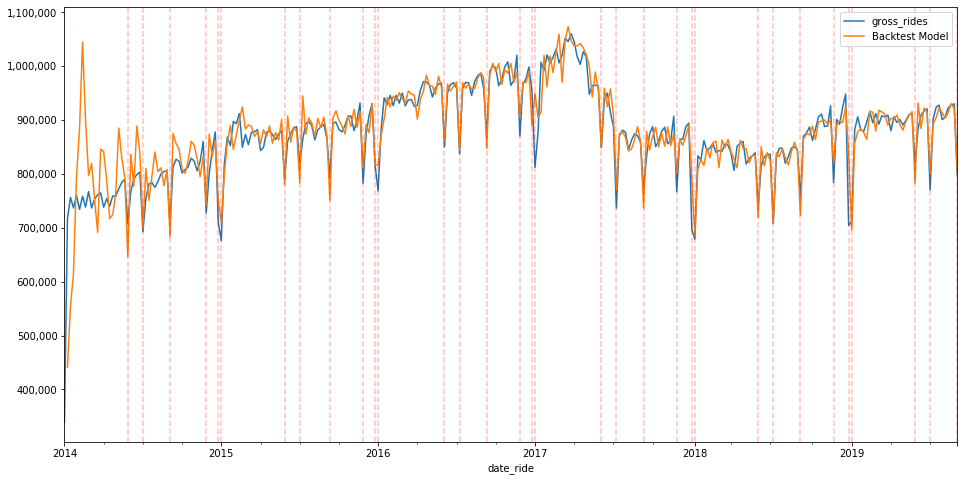

In [82]:
plot_fit(train[series], backtest, train)

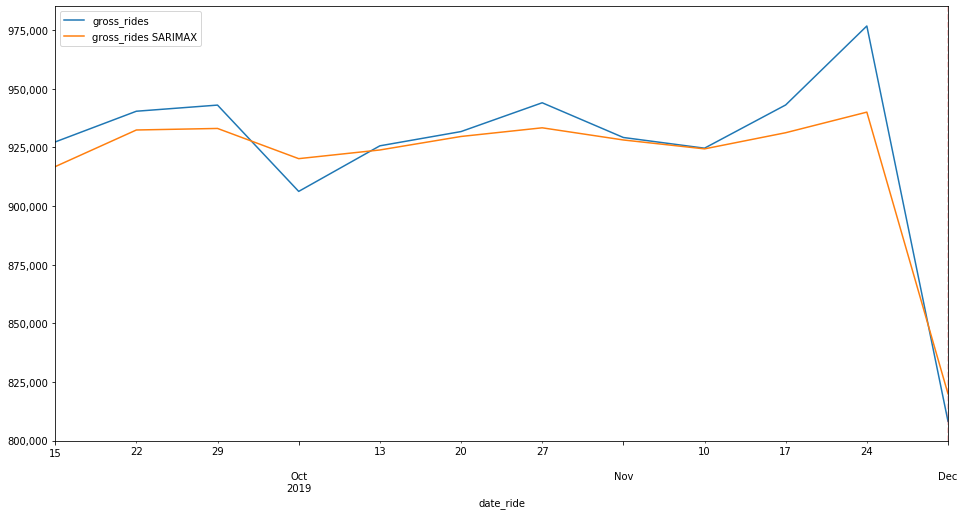

In [86]:
prediction_plot(test[series], predictions, vp=False)

In [105]:
compare = compare_results(test[series], predictions, vp =False)

compare.head().style.format("{:,.0f}")

In [118]:
error_calcs(compare, predictions, test[series])

In [89]:
calculate_total_error(test[series], predictions)

13588 RMSE
924949 Mean of Rides
1.5 % Error


In [119]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [120]:
intervals

In [121]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Rides

In [122]:
series = 'verified_paid_rides'

In [123]:
model = build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               verified_paid_rides   No. Observations:                  297
Model:             SARIMAX(1, 0, 1)x(2, 1, 0, 5)   Log Likelihood               -3408.735
Date:                           Fri, 03 Jan 2020   AIC                           6829.471
Time:                                   14:31:10   BIC                           6851.532
Sample:                               01-05-2014   HQIC                          6838.308
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.338e+05   3503.899    -38.186      0.000   -1.41e+05   -1.27e+05
ar.L1          0.8986      0.018     49.789      0.000       0.863       0.934
ma.L1         -0.7248      0.040    -18.002      0.000      -0.804      -0.646
ar.S.L5       -0.4396      0.048     -9.118      0.000      -0.534      -0.345
ar.S.L10      -0.1659      0.046     -3.624      0.000      -0.256      -0.076
sigma2      9.528e+08      0.015   6.32e+10      0.000    9.53e+08    9.53e+08
===================================================================================
Ljung-Box (Q):                       53.30   Jarque-Bera (JB):                49.91
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.47
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.57e+26. Standard errors may be unstable.
"""

In [124]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

0.7388960900376336

In [125]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [126]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

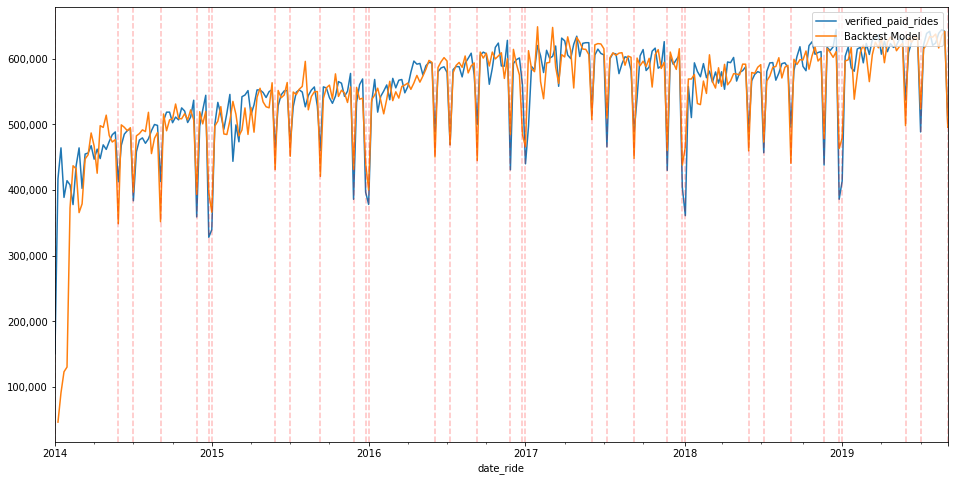

In [127]:
plot_fit(train[series], backtest, train)

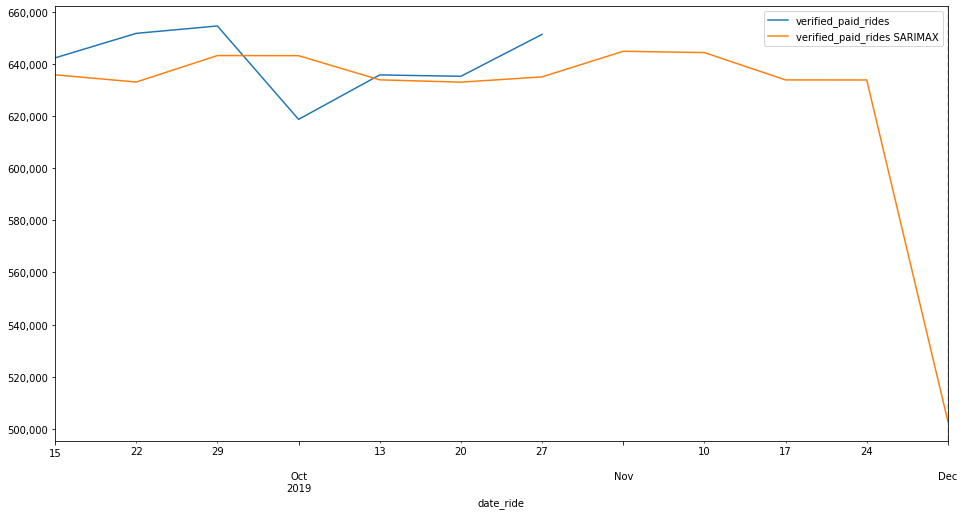

In [128]:
prediction_plot(test[series], predictions, vp = True)

In [129]:
compare = compare_results(test[series], predictions, vp= True)

compare.head().style.format("{:,.0f}")

In [130]:
error_calcs(compare, predictions, test[series])

In [131]:
calculate_total_error(test[series], predictions, vp=True)

14116 RMSE
641502 Mean of Rides
2.2 % Error


In [134]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions,
                  vp = True)

In [135]:
intervals

In [136]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Costs

In [137]:
series = 'verified_paid_costs'

In [138]:
model = build_model(train[series],
                       p=2,
                       d=0,
                       q=0,
                       S=2,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               verified_paid_costs   No. Observations:                  297
Model:             SARIMAX(2, 0, 0)x(2, 1, 1, 2)   Log Likelihood               -4420.258
Date:                           Fri, 03 Jan 2020   AIC                           8854.516
Time:                                   14:32:36   BIC                           8880.324
Sample:                               01-05-2014   HQIC                          8864.850
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -3.741e+06   2.88e-09   -1.3e+15      0.000   -3.74e+06   -3.74e+06
ar.L1          0.5204      0.034     15.317      0.000       0.454       0.587
ar.L2          0.4745      0.034     13.779      0.000       0.407       0.542
ar.S.L2       -0.2716      0.033     -8.142      0.000      -0.337      -0.206
ar.S.L4       -0.1275      0.056     -2.271      0.023      -0.238      -0.017
ma.S.L2       -0.9801      0.025    -38.802      0.000      -1.030      -0.931
sigma2      6.638e+11   2.73e-14   2.43e+25      0.000    6.64e+11    6.64e+11
===================================================================================
Ljung-Box (Q):                       46.33   Jarque-Bera (JB):               179.20
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.16
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+40. Standard errors may be unstable.
"""

In [139]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.3465632572064616

In [140]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [141]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

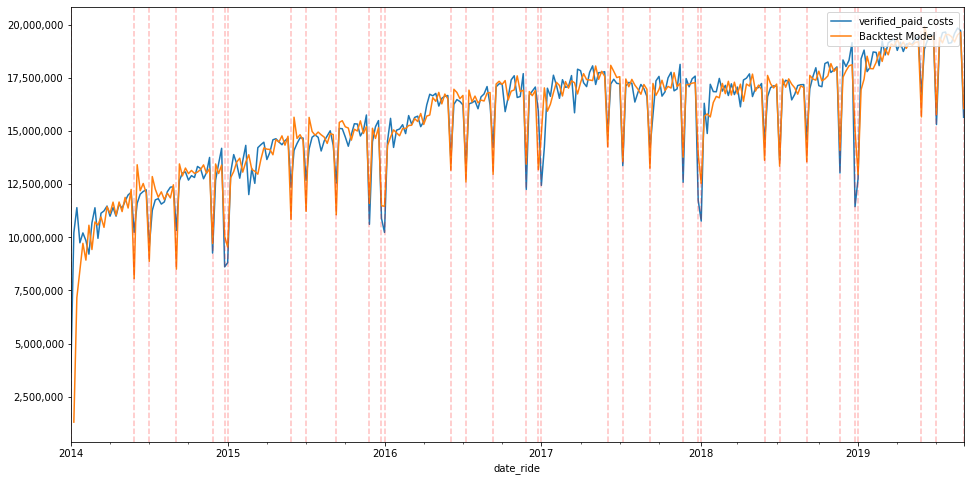

In [142]:
plot_fit(train[series], backtest, train)

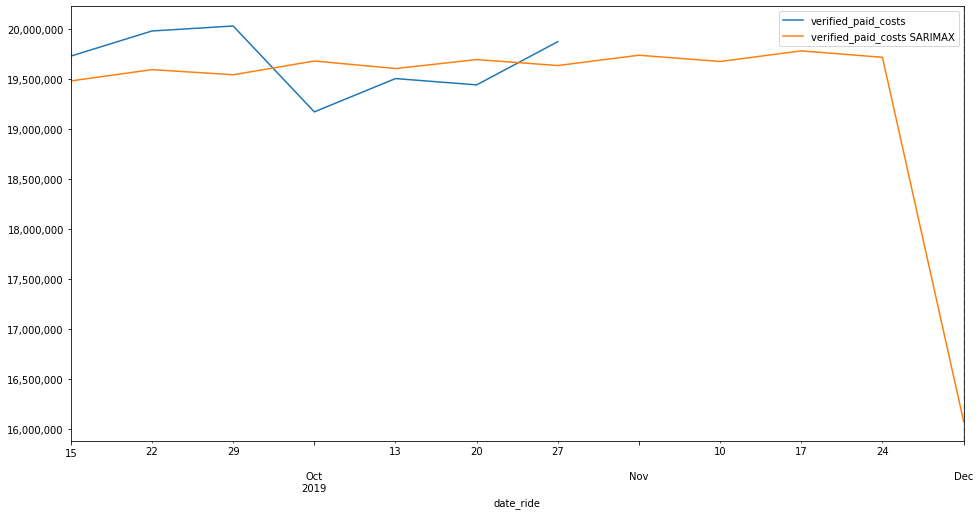

In [143]:
prediction_plot(test[series], predictions, vp=True)

In [144]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [145]:
error_calcs(compare, predictions, test[series])

In [146]:
calculate_total_error(test[series], predictions)

345861 RMSE
19672503 Mean of Rides
1.8 % Error


In [147]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [148]:
intervals

In [149]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Miles

In [150]:
series = 'verified_paid_miles'

In [151]:
model = build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               verified_paid_miles   No. Observations:                  297
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 5)   Log Likelihood               -4282.741
Date:                           Fri, 03 Jan 2020   AIC                           8577.481
Time:                                   14:33:34   BIC                           8599.521
Sample:                               01-05-2014   HQIC                          8586.311
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.486e+06   7.33e+04    -20.255      0.000   -1.63e+06   -1.34e+06
ar.L1          0.1751      0.080      2.190      0.029       0.018       0.332
ma.L1         -0.6948      0.073     -9.556      0.000      -0.837      -0.552
ar.S.L5       -0.5630      0.038    -15.000      0.000      -0.637      -0.489
ar.S.L10      -0.2870      0.041     -6.950      0.000      -0.368      -0.206
sigma2      4.336e+11      0.190   2.28e+12      0.000    4.34e+11    4.34e+11
===================================================================================
Ljung-Box (Q):                       67.58   Jarque-Bera (JB):              2266.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.63e+26. Standard errors may be unstable.
"""

In [152]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.6367912909972164

In [153]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [154]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

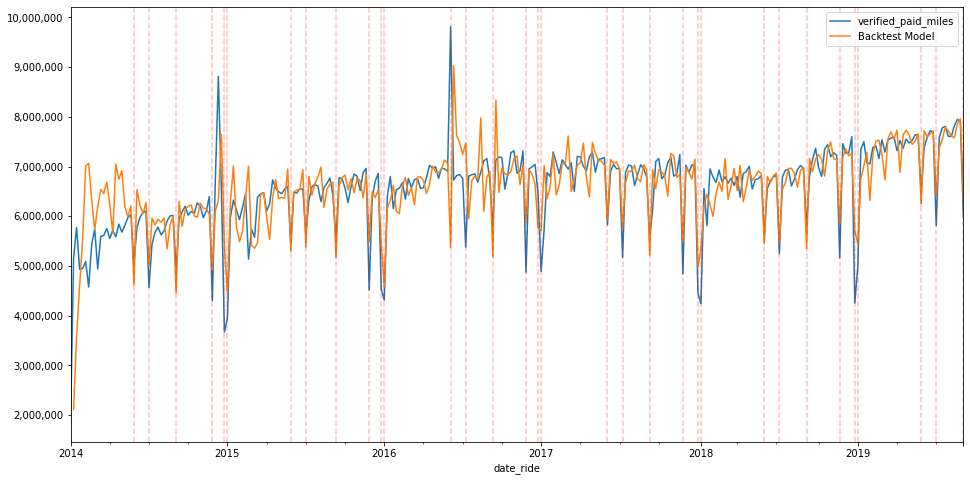

In [155]:
plot_fit(train[series], backtest, train)

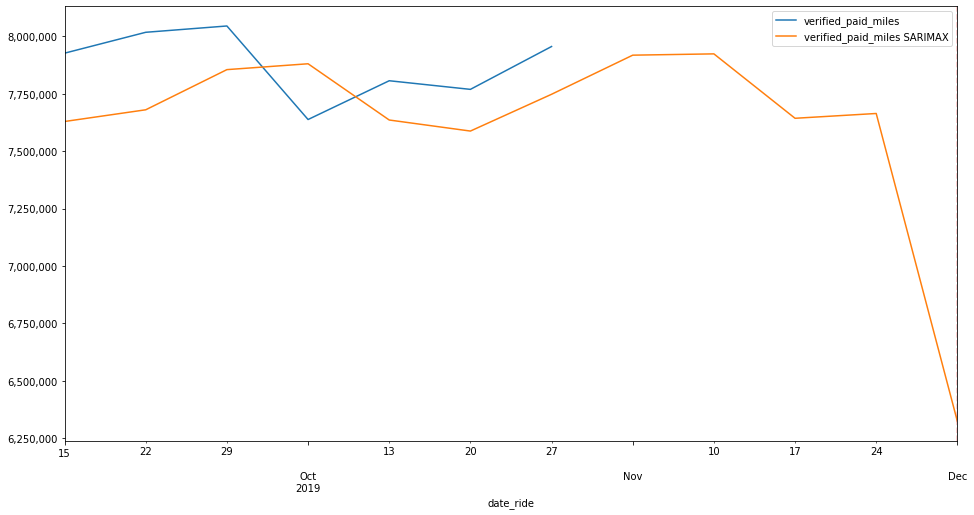

In [156]:
prediction_plot(test[series], predictions, vp=True)

In [157]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [158]:
error_calcs(compare, predictions, test[series])

In [159]:
calculate_total_error(test[series], predictions)

239978 RMSE
7879695 Mean of Rides
3.0 % Error


In [160]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [161]:
intervals

In [162]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Ambulatory Rides

In [163]:
series = 'verified_paid_ambulatory_rides'

In [164]:
model = build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     verified_paid_ambulatory_rides   No. Observations:                  297
Model:              SARIMAX(2, 1, 1)x(2, 1, 1, 4)   Log Likelihood               -3385.791
Date:                            Fri, 03 Jan 2020   AIC                           6787.582
Time:                                    14:34:20   BIC                           6816.996
Sample:                                01-05-2014   HQIC                          6799.364
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -9.649e+04   3121.861    -30.907      0.000   -1.03e+05   -9.04e+04
ar.L1         -0.9124      0.083    -10.935      0.000      -1.076      -0.749
ar.L2         -0.1150      0.039     -2.946      0.003      -0.192      -0.039
ma.L1          0.9162      0.092      9.993      0.000       0.737       1.096
ar.S.L4        0.3623      0.059      6.184      0.000       0.247       0.477
ar.S.L8        0.0647      0.041      1.590      0.112      -0.015       0.144
ma.S.L4       -0.9436      0.044    -21.207      0.000      -1.031      -0.856
sigma2      7.632e+08      0.052   1.47e+10      0.000    7.63e+08    7.63e+08
===================================================================================
Ljung-Box (Q):                       91.72   Jarque-Bera (JB):               661.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.66e+25. Standard errors may be unstable.
"""

In [165]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.1646037856539222

In [166]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [167]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

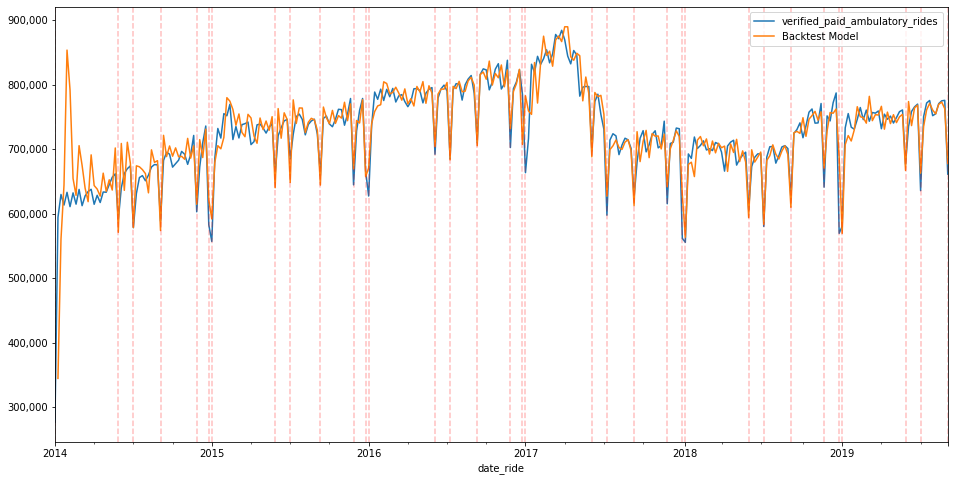

In [168]:
plot_fit(train[series], backtest, train)

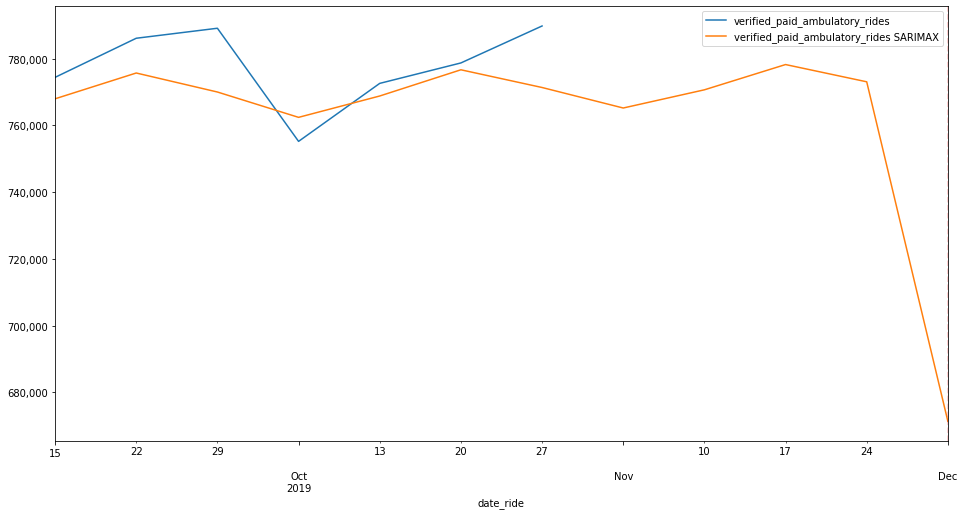

In [169]:
prediction_plot(test[series], predictions, vp=True)

In [170]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [171]:
error_calcs(compare, predictions, test[series])

In [172]:
calculate_total_error(test[series], predictions)

11498 RMSE
777990 Mean of Rides
1.5 % Error


In [173]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [174]:
intervals

In [175]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Ambulatory Costs

In [176]:
series = 'verified_paid_ambulatory_costs'

In [177]:
model = build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     verified_paid_ambulatory_costs   No. Observations:                  297
Model:              SARIMAX(1, 0, 1)x(2, 1, 0, 5)   Log Likelihood               -4296.255
Date:                            Fri, 03 Jan 2020   AIC                           8604.511
Time:                                    14:37:34   BIC                           8626.571
Sample:                                01-05-2014   HQIC                          8613.347
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.764e+06   7.59e+04    -36.427      0.000   -2.91e+06   -2.62e+06
ar.L1          0.9104      0.020     45.045      0.000       0.871       0.950
ma.L1         -0.7514      0.048    -15.648      0.000      -0.846      -0.657
ar.S.L5       -0.4515      0.050     -9.045      0.000      -0.549      -0.354
ar.S.L10      -0.1893      0.049     -3.856      0.000      -0.285      -0.093
sigma2      4.239e+11      0.004   1.16e+14      0.000    4.24e+11    4.24e+11
===================================================================================
Ljung-Box (Q):                       55.63   Jarque-Bera (JB):                26.63
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.39
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+30. Standard errors may be unstable.
"""

In [178]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

0.8355558683074318

In [179]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [180]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

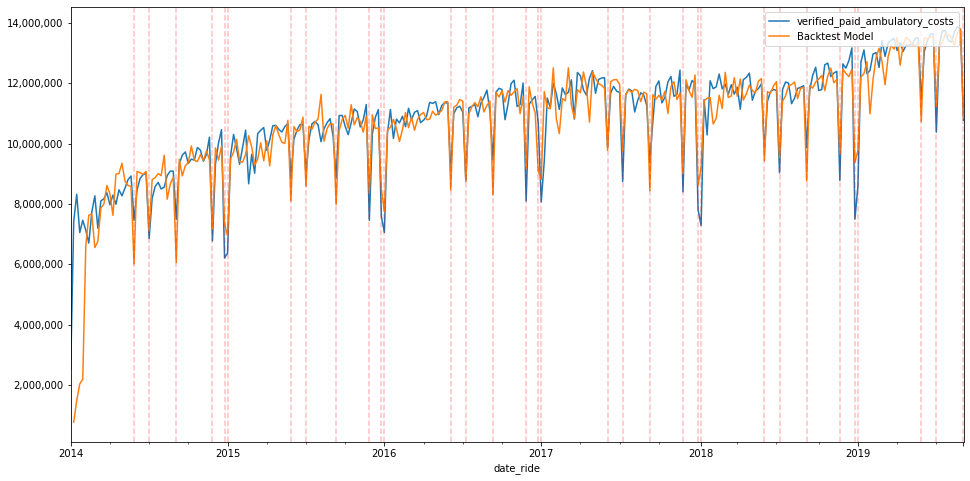

In [181]:
plot_fit(train[series], backtest, train)

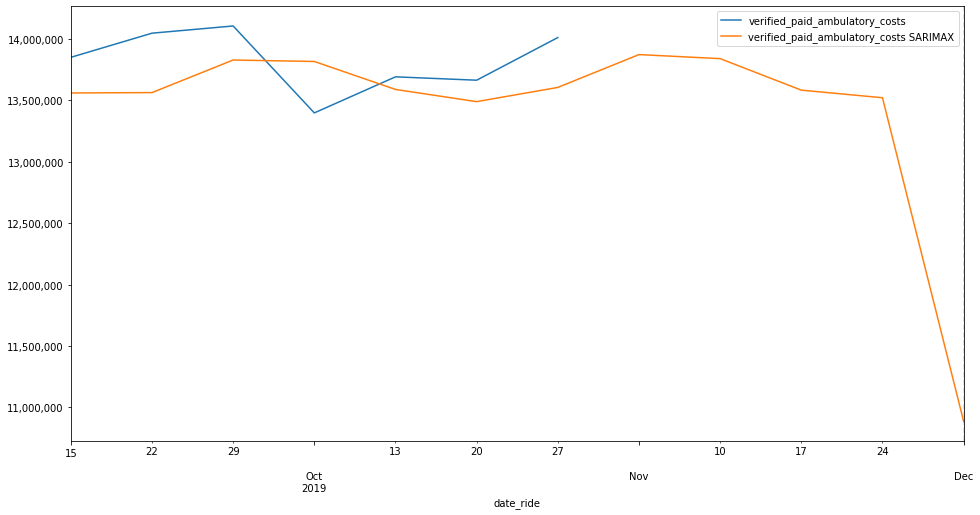

In [182]:
prediction_plot(test[series], predictions, vp=True)

In [183]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [184]:
error_calcs(compare, predictions, test[series])

In [185]:
calculate_total_error(test[series], predictions)

333250 RMSE
13824865 Mean of Rides
2.4 % Error


In [186]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [187]:
intervals

In [188]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Stretcher Rides

In [189]:
series = 'verified_paid_stretcher_rides'

In [210]:
model = build_model(train[series],
                       p=1,
                       d=1,
                       q=2,
                       S=6,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:     verified_paid_stretcher_rides   No. Observations:                  297
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 6)   Log Likelihood               -2234.205
Date:                           Fri, 03 Jan 2020   AIC                           4484.409
Time:                                   14:40:48   BIC                           4513.768
Sample:                               01-05-2014   HQIC                          4496.172
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1450.0434     71.225    -20.359      0.000   -1589.642   -1310.445
ar.L1         -0.2450      0.218     -1.126      0.260      -0.671       0.181
ma.L1          0.1504      0.225      0.667      0.505      -0.291       0.592
ma.L2         -0.2858      0.050     -5.722      0.000      -0.384      -0.188
ar.S.L6       -0.9999      0.054    -18.449      0.000      -1.106      -0.894
ma.S.L6        0.0701      0.141      0.496      0.620      -0.207       0.347
ma.S.L12      -0.9291      0.091    -10.228      0.000      -1.107      -0.751
sigma2        2.7e+05      0.002   1.26e+08      0.000     2.7e+05     2.7e+05
===================================================================================
Ljung-Box (Q):                       54.09   Jarque-Bera (JB):               468.57
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.86e+24. Standard errors may be unstable.
"""

In [211]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

0.9866446735301209

In [212]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [213]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

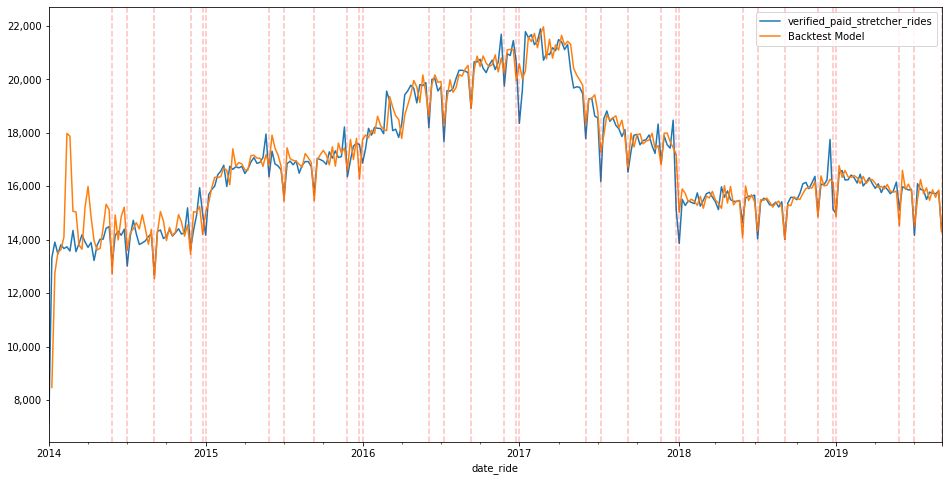

In [214]:
plot_fit(train[series], backtest, train)

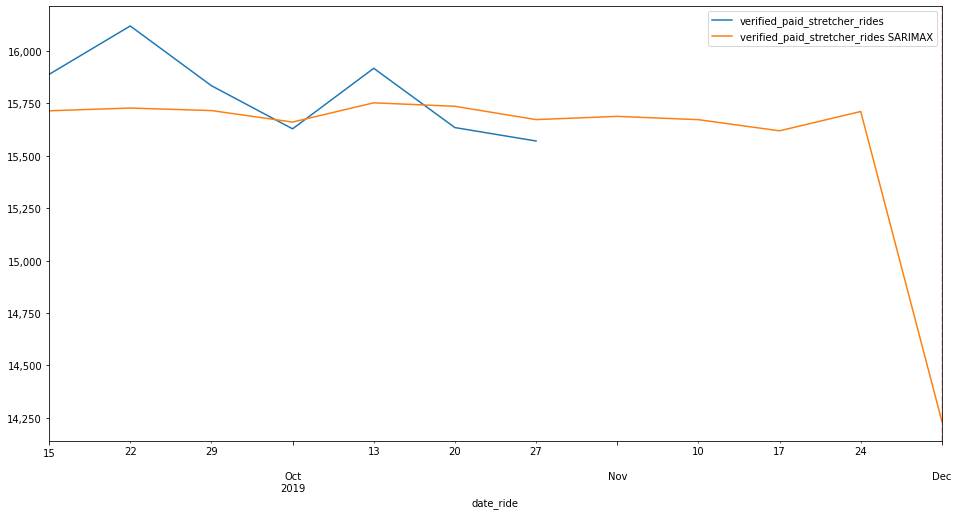

In [215]:
prediction_plot(test[series], predictions, vp=True)

In [216]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [217]:
error_calcs(compare, predictions, test[series])

In [218]:
calculate_total_error(test[series], predictions)

188 RMSE
15800 Mean of Rides
1.2 % Error


In [219]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [220]:
intervals

In [221]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Stretcher Costs

In [222]:
series = 'verified_paid_stretcher_costs'

In [233]:
model = build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=6,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:     verified_paid_stretcher_costs   No. Observations:                  297
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -3664.384
Date:                           Fri, 03 Jan 2020   AIC                           7340.768
Time:                                   14:42:58   BIC                           7362.787
Sample:                               01-05-2014   HQIC                          7349.590
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.173e+05   1.24e+04    -17.555      0.000   -2.42e+05   -1.93e+05
ar.L1          0.0018      0.207      0.009      0.993      -0.404       0.407
ma.L1         -0.4653      0.187     -2.493      0.013      -0.831      -0.099
ar.S.L6        0.0589      0.099      0.594      0.553      -0.136       0.253
ma.S.L6       -0.9073      0.073    -12.492      0.000      -1.050      -0.765
sigma2      8.224e+09      0.092    8.9e+10      0.000    8.22e+09    8.22e+09
===================================================================================
Ljung-Box (Q):                       62.86   Jarque-Bera (JB):                88.07
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                            -0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+25. Standard errors may be unstable.
"""

In [234]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.6215843745569514

In [235]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [236]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

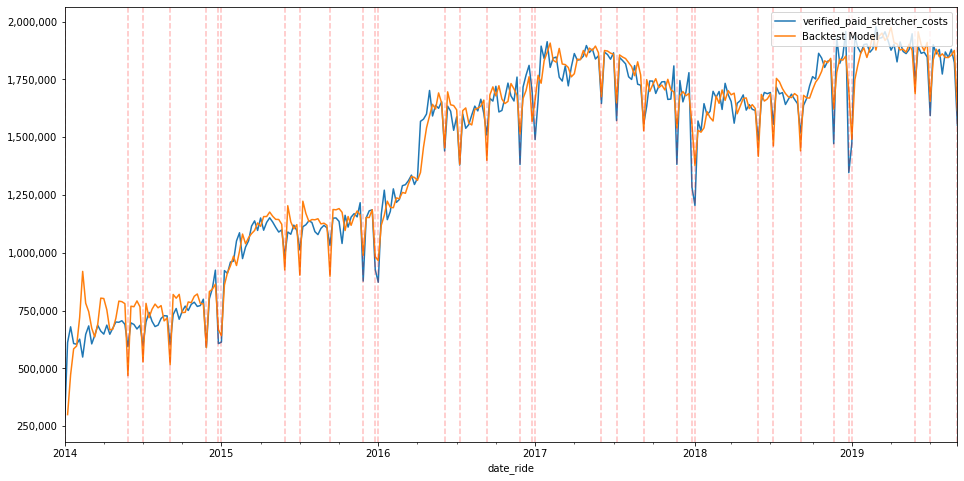

In [237]:
plot_fit(train[series], backtest, train)

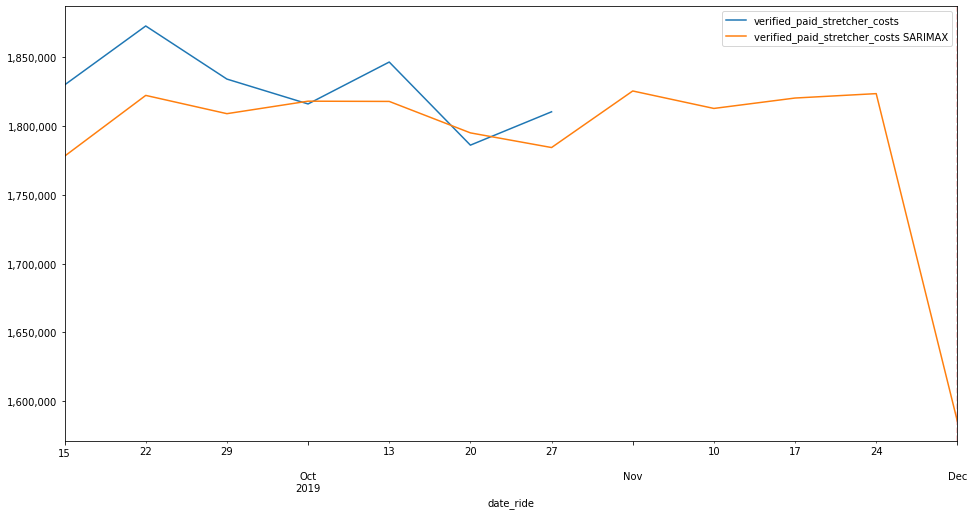

In [238]:
prediction_plot(test[series], predictions, vp = True)

In [239]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [240]:
error_calcs(compare, predictions, test[series])

In [241]:
calculate_total_error(test[series], predictions)

32613 RMSE
1828002 Mean of Rides
1.8 % Error


In [242]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [243]:
intervals

In [244]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verfied Paid Wheelchair Rides

In [245]:
series = 'verified_paid_wheelchair_rides'

In [263]:
model = build_model(train[series],
                       p=0,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     verified_paid_wheelchair_rides   No. Observations:                  297
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -2779.525
Date:                            Fri, 03 Jan 2020   AIC                           5571.050
Time:                                    14:52:04   BIC                           5592.944
Sample:                                01-05-2014   HQIC                          5579.828
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.107e+04    530.310    -20.875      0.000   -1.21e+04      -1e+04
ma.L1          0.1602      0.032      4.934      0.000       0.097       0.224
ma.L2         -0.1487      0.060     -2.460      0.014      -0.267      -0.030
ar.S.L12       0.2072      0.043      4.806      0.000       0.123       0.292
ma.S.L12      -0.8697      0.049    -17.910      0.000      -0.965      -0.775
sigma2      2.175e+07      0.030   7.25e+08      0.000    2.18e+07    2.18e+07
===================================================================================
Ljung-Box (Q):                       95.24   Jarque-Bera (JB):               317.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.98
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+24. Standard errors may be unstable.
"""

In [264]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.232241486028228

In [265]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [266]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

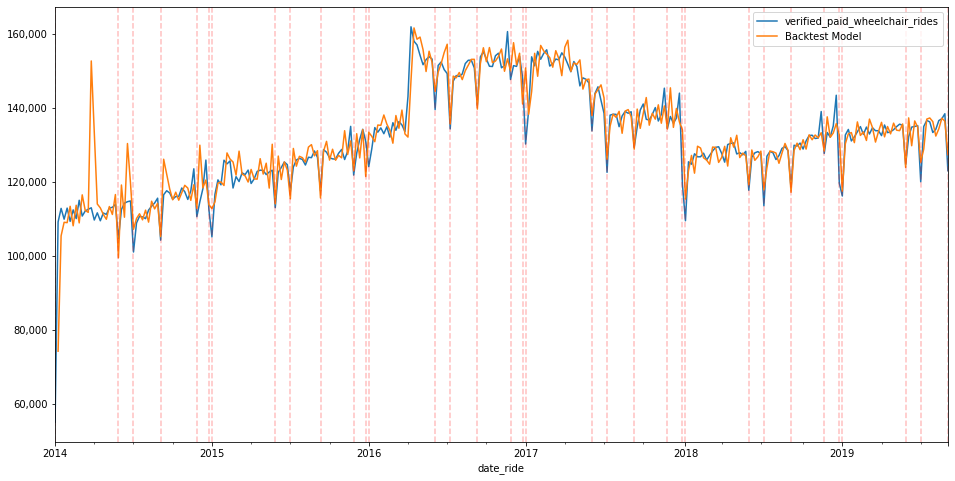

In [267]:
plot_fit(train[series], backtest, train)

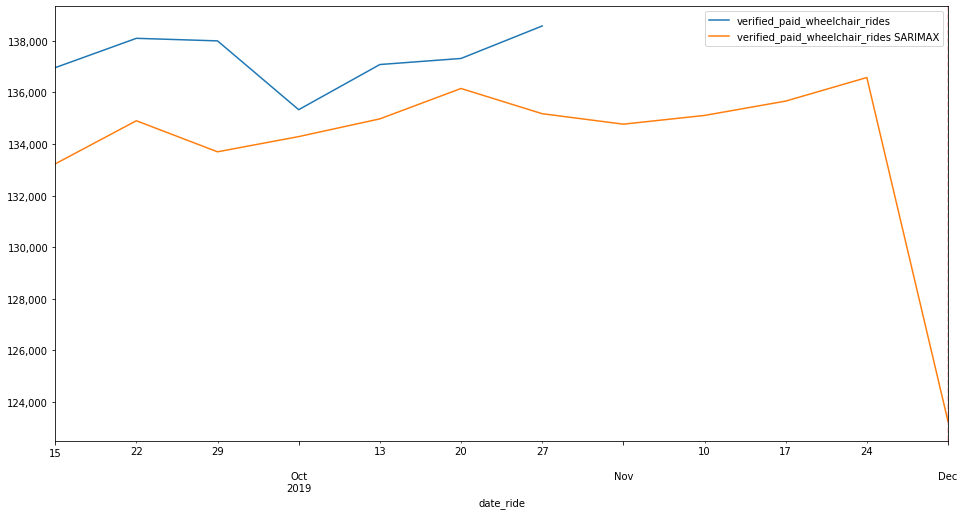

In [268]:
prediction_plot(test[series], predictions, vp=True)

In [269]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [270]:
error_calcs(compare, predictions, test[series])

In [271]:
calculate_total_error(test[series], predictions)

2951 RMSE
137331 Mean of Rides
2.1 % Error


In [272]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [273]:
intervals

In [274]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Verified Paid Wheelchair Costs

In [275]:
series = 'verified_paid_wheelchair_costs'

In [292]:
model = build_model(train[series],
                       p=1,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=0,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     verified_paid_wheelchair_costs   No. Observations:                  297
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3836.255
Date:                            Fri, 03 Jan 2020   AIC                           7686.511
Time:                                    14:55:57   BIC                           7712.054
Sample:                                01-05-2014   HQIC                          7696.751
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.977e+05   2.41e+04    -24.835      0.000   -6.45e+05    -5.5e+05
ar.L1         -0.7405      0.221     -3.345      0.001      -1.174      -0.307
ma.L1          0.4294      0.231      1.857      0.063      -0.024       0.883
ma.L2         -0.3574      0.066     -5.413      0.000      -0.487      -0.228
ma.S.L12      -0.7929      0.061    -13.035      0.000      -0.912      -0.674
ma.S.L24      -0.0579      0.056     -1.034      0.301      -0.168       0.052
sigma2      4.162e+10      0.043   9.69e+11      0.000    4.16e+10    4.16e+10
===================================================================================
Ljung-Box (Q):                       49.69   Jarque-Bera (JB):                78.14
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.78
Prob(H) (two-sided):                  0.84   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+27. Standard errors may be unstable.
"""

In [293]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.4727484639022927

In [294]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [295]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

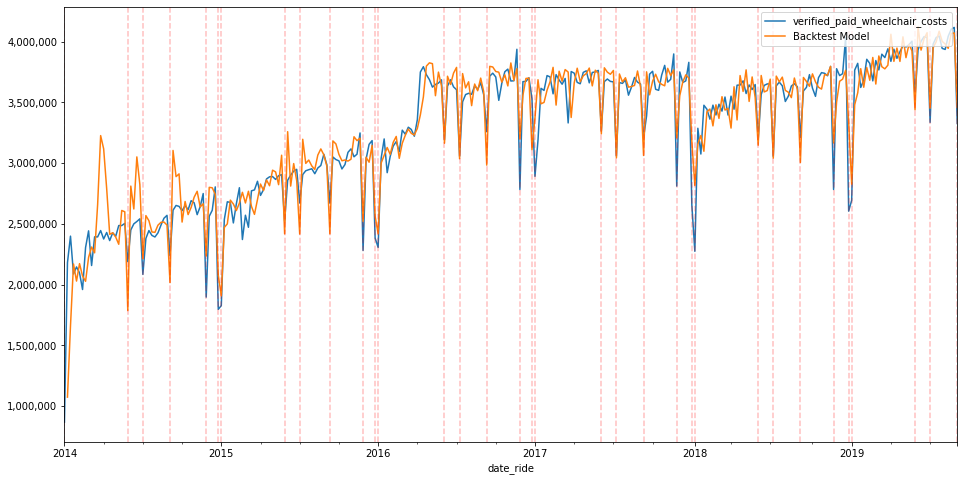

In [296]:
plot_fit(train[series], backtest, train)

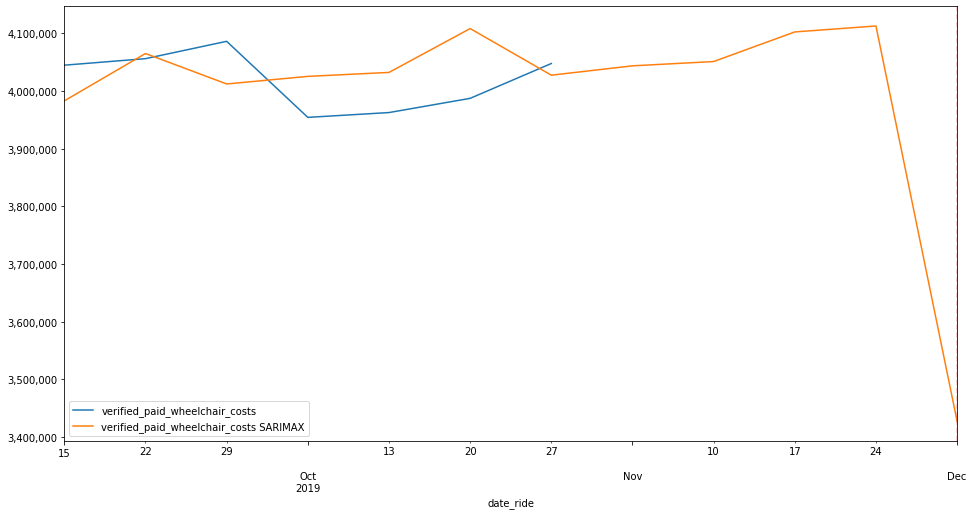

In [297]:
prediction_plot(test[series], predictions, vp = True)

In [298]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [299]:
error_calcs(compare, predictions, test[series])

In [300]:
calculate_total_error(test[series], predictions)

70020 RMSE
4019636 Mean of Rides
1.7 % Error


In [301]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [302]:
intervals

In [303]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# Riders

In [304]:
series = 'riders'

In [310]:
model = build_model(train[series],
                       p=0,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  297
Model:             SARIMAX(0, 1, 2)x(2, 1, 1, 12)   Log Likelihood               -3141.762
Date:                            Fri, 03 Jan 2020   AIC                           6297.525
Time:                                    14:57:08   BIC                           6323.068
Sample:                                01-05-2014   HQIC                          6307.766
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.478e+04   1889.865    -28.985      0.000   -5.85e+04   -5.11e+04
ma.L1          0.0211      0.031      0.675      0.500      -0.040       0.082
ma.L2         -0.1111      0.049     -2.280      0.023      -0.207      -0.016
ar.S.L12       0.1418      0.046      3.074      0.002       0.051       0.232
ar.S.L24      -0.1166      0.038     -3.042      0.002      -0.192      -0.041
ma.S.L12      -0.8382      0.047    -17.833      0.000      -0.930      -0.746
sigma2      2.558e+08      0.000   9.82e+11      0.000    2.56e+08    2.56e+08
===================================================================================
Ljung-Box (Q):                      156.47   Jarque-Bera (JB):               300.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.15e+29. Standard errors may be unstable.
"""

In [311]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.2360919303518745

In [312]:
backtest = backtest_model(model,
                           exog_data=train['holiday'][1:],
                           start=len(train))

In [313]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=test[['holiday']])

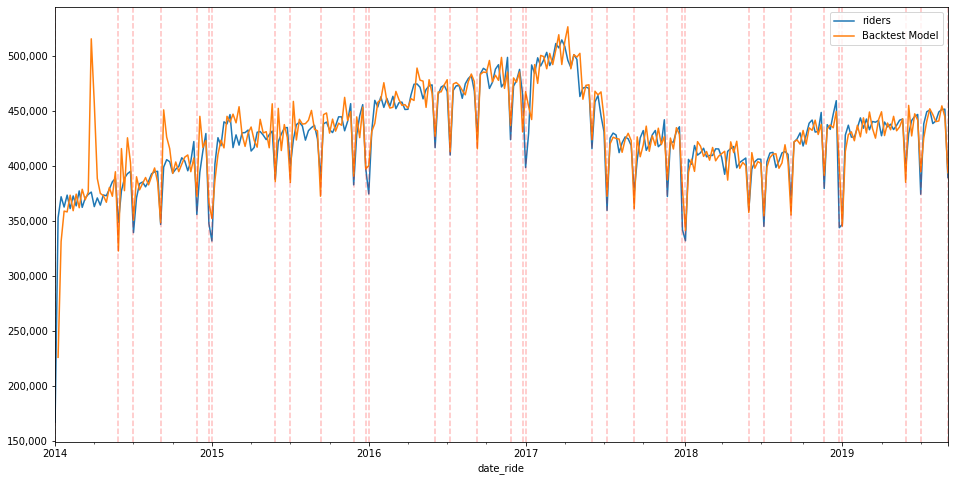

In [314]:
plot_fit(train[series], backtest, train)

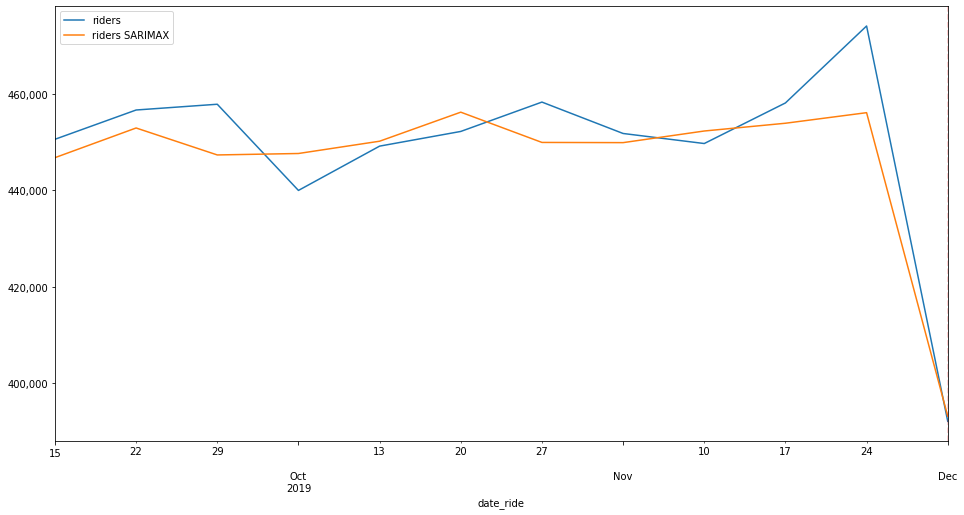

In [315]:
prediction_plot(test[series], predictions)

In [316]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.0f}")

In [317]:
error_calcs(compare, predictions, test[series])

In [318]:
calculate_total_error(test[series], predictions)

6389 RMSE
452137 Mean of Rides
1.4 % Error


In [319]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = test[['holiday']],               
                  predictions=predictions)

In [320]:
intervals

In [321]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

# CPM

In [322]:
series = 'cpm'

In [429]:
model = build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=4,
                       exog_data = None,
                       P=1,
                       D=0,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                               cpm   No. Observations:                  297
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                 312.064
Date:                           Fri, 03 Jan 2020   AIC                           -614.128
Time:                                   15:24:14   BIC                           -595.660
Sample:                               01-05-2014   HQIC                          -606.735
                                    - 09-08-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.001    950.366      0.000       0.997       1.002
ma.L1         -0.8620      0.027    -31.366      0.000      -0.916      -0.808
ar.S.L4        0.9993      0.003    292.287      0.000       0.993       1.006
ma.S.L4       -0.9945      0.013    -76.883      0.000      -1.020      -0.969
sigma2         0.0068      0.000     30.544      0.000       0.006       0.007
===================================================================================
Ljung-Box (Q):                       15.71   Jarque-Bera (JB):             76066.26
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -6.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        80.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [430]:
# check the durbin watson on the residuals
# look for a value close to 2

get_dw(model)

1.28937742712622

In [431]:
backtest = backtest_model(model,
                           exog_data=None,
                           start=len(train))

In [432]:
# make_predictions(model_results, model_name, start, exog_data):
# end = len(train) + len(test)-1


predictions = make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(test)-1,
                               exog_data=None)

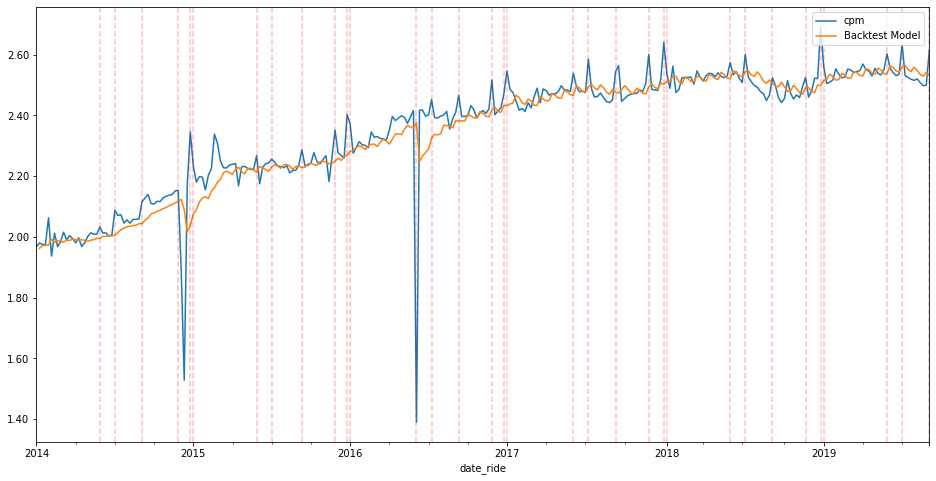

In [433]:
plot_fit(train[series], backtest, train, decimal=True)

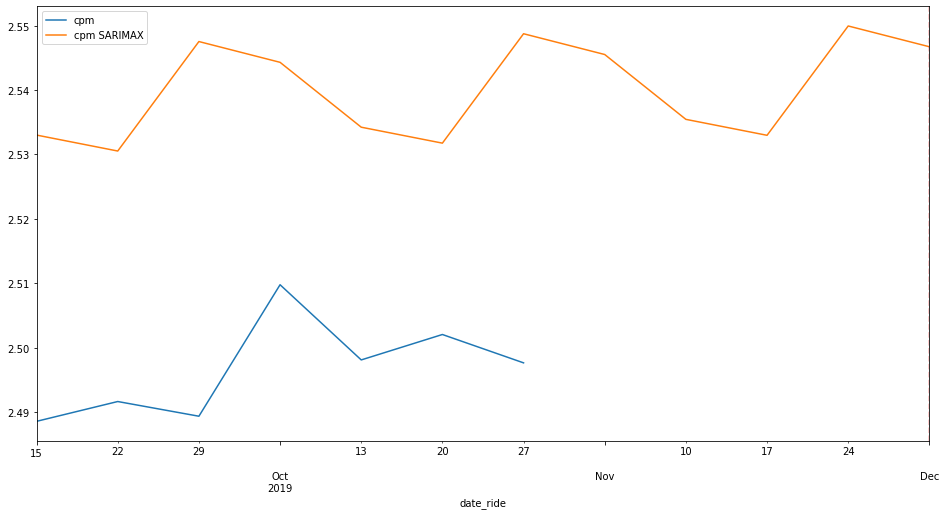

In [434]:
prediction_plot(test[series], predictions, vp = True, decimal=True)

In [435]:
compare = compare_results(test[series], predictions)

compare.head().style.format("{:,.2f}")

In [436]:
error_calcs(compare, predictions, test[series])

In [437]:
calculate_total_error(test[series], predictions)

0 RMSE
2 Mean of Rides
1.7 % Error


In [438]:
intervals = get_conf_interval(model=model,
                  actual=test[series],
                  steps_ahead=horizon,
                  exog_data = None,               
                  predictions=predictions)

In [439]:
intervals.format("{:,.2f}")

In [440]:
month = monthly_rollup(model=model,
                       actual=test[series],
                       steps_ahead=horizon,
                       exog_data = test[['holiday']],
                       predictions=predictions)

month

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)
